# Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from decimal import Decimal
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *

np.random.seed(1234)
plt.style.use('default')
pd.set_option('display.max_columns', None)

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Quick Links

<ol>
    <li><a href=#effect_table>Effect Alleles Table</a></li>
    <li><a href=#effect_viz>Effect Alleles Visual</a></li>
    <li><a href=#noneffect_table>Non-Effect Alleles Table</a></li>
    <li><a href=#noneffect_viz>Non-Effect Alleles Visual</a></li>
</ol>

# Cluster 1

In [2]:
cluster = '2'

## Prepare Effect and Non-Effect Scores

In [3]:
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print("Num effect sequences:", len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'+cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)

Num effect sequences: 510
Num noneffect sequences: 510


## Prepare DataFrame

In [4]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/ld_buddies_table_stage3.tsv', sep='\t')
effect_score = []
noneffect_score = []
effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
allele_ratio = []
allele_diff = []
effect_rank = []
noneffect_rank = []
ism_score = []
delta_score = []
idr_peak = []
all_gwas = []
coloc = []
for index,row in snps.iterrows():
    effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
    noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
    effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
    noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
    effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
    noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
    allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
    #allele_diff.append(effect_center[-1] - noneffect_center[-1])
    allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]])) - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
    effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
    noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        gwas_list.append(rw['source_gwas']+': '+str('%.2E' % Decimal(rw['pvalue'])))
        if rw['has_coloc'] == True:
            has_coloc = True
    all_gwas.append(gwas_list)
    coloc.append(has_coloc)
snps['effect_score'] = effect_score
snps['noneffect_score'] = noneffect_score
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['allele_ratio'] = allele_ratio
snps['allele_diff'] = allele_diff
snps['effect_rank'] = effect_rank
snps['noneffect_rank'] = noneffect_rank
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['idr_peak'] = idr_peak
snps['all_gwas'] = all_gwas
snps['coloc'] = coloc
snps.sort_values(by=['allele_ratio'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)

## Find Effect Alleles that Break Accessibility <a name='effect_table' />

In [5]:
neg_snps = snps.loc[snps['allele_ratio'] <= 1]
neg_snps.sort_values(by=['noneffect_rank'], ascending=False, inplace=True)
display(neg_snps)

chr      start        end         rsid effect noneffect ref    alt  \
48   chr12   33530906   33530907     rs935534      G         A   G      A   
314  chr19   45001090   45001091   rs35577563      C         G   C      G   
451   chr4   89837895   89837896    rs2619363    NAN       NAN   G    C,T   
175  chr17   45894090   45894091   rs76594404      G         C   G    A,C   
383   chr3   49053262   49053263    rs7373790      T         C   T    A,C   
226  chr17   46061823   46061824    rs2316952      G         C   G      C   
95   chr17    4842178    4842179    rs7218117      A         G   A      G   
401   chr3  122458998  122458999   rs56118506      T         C   C      T   
15   chr11   47340286   47340287    rs2596407      A         G   A      G   
97   chr17    4842203    4842204    rs7218130      A         G   A      G   
509   chr9   34024957   34024958    rs1758631      T         G   G    A,T   
30   chr11   47731222   47731223   rs17788930      A         G   A      G   
282  chr19   44644418   44644419   rs10426401      T         G   T      G   
457   chr5  102971887  102971888    rs6881225      T         C   T      C   
246  chr17   62065536   62065537  rs118039704      G         A   G      A   
86   chr16   31088461   31088462   rs17839568      T         C   T      C   
156  chr17   45771271   45771272   rs62055934      G         A   G      A   
172  chr17   45852871   45852872   rs79589869      C         A   C      A   
180  chr17   45894775   45894776   rs11575896      G         A   G      A   
134  chr17   45639518   45639519     rs413778      A         G   A      G   
181  chr17   45895214   45895215   rs74457229      T         C   C      T   
376   chr3   48692682   48692683   rs12493578      T         C   T      C   
332  chr19   45187691   45187692   rs12463049      G         C   C      G   
471   chr6   27754284   27754285    rs4713121      T         C   T      C   
269  chr19   18462023   18462024    rs8103622      T         C   C      T   
186  chr17   45896046   45896047   rs78720789      G         A   A      G   
178  chr17   45894418   45894419   rs11575895      G         A   A      G   
296  chr19   44954426   44954427   rs10426750      C         G   G    A,C   
116  chr17   45386126   45386127   rs79724577      C         A   A      C   
301  chr19   44954977   44954978   rs41334244      G         A   A      G   
..     ...        ...        ...          ...    ...       ...  ..    ...   
123  chr17   45436184   45436185       rs9730      C         G   C    A,G   
257  chr18   43092998   43092999    rs4588066      G         A   G      A   
32   chr11   60265897   60265898    rs7930318      T         C   C      T   
259  chr18   51195709   51195710   rs62092913      G         A   A      G   
174  chr17   45870561   45870562   rs56289364      G         A   A      G   
313  chr19   44989300   44989301   rs11669173      G         A   G      A   
298  chr19   44954888   44954889    rs3760629      C         A   A      C   
493   chr8   22622474   22622475   rs11136093      G         C   C      G   
284  chr19   44657627   44657628   rs10410651      T         C   T      C   
477   chr6  132812798  132812799   rs79333841      G         C   C    G,T   
308  chr19   44967655   44967656   rs10775543      T         C   C  A,G,T   
231  chr17   46130777   46130778   rs17661428      G         C   C      G   
420   chr4   89753279   89753280     rs356168      G         A   G      A   
478   chr7   23086302   23086303    rs9691762      C         G   G    A,C   
62   chr14   54903566   54903567   rs10136972      G         A   A      G   
291  chr19   44891078   44891079   rs71352238      C         T   T      C   
255  chr17   75035407   75035408   rs80319906      A         G   G      A   
114  chr17   44220262   44220263  rs113844752      C         A   C    A,G   
37   chr11   83827385   83827386    rs2040313      G         A   G      A   
141  chr17   45704059   45704060   rs62056879      T         C   T      C   
439

## Visualize Top Effect Alleles <a name='effect_viz' />

RSID: rs935534   ||    chr12 : 33530906 - 33530907   ||    Locus: 48   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.46E-07

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.8754   ||   Center / 200bp : 0.6133
Noneffect Sequence : TTTTGTCTTAGTCAGATGCT


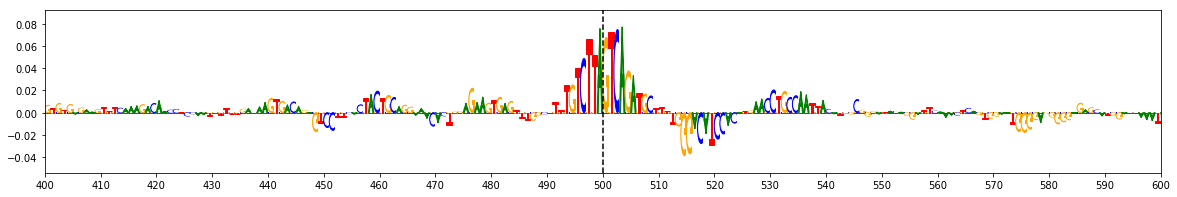

Effect Allele : G   ||   Explain Score : 0.1395   ||   Center / 200bp : 0.2016
Effect Sequence : TTTTGTCTTGGTCAGATGCT


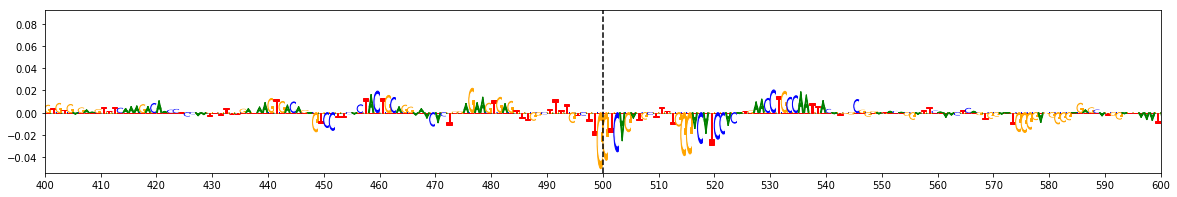

Allele Ratio : 0.1593   ||   Allele Difference : -0.9884  ||  ISM Score : -1.5593  ||  deltaSVM Score : -8.8656


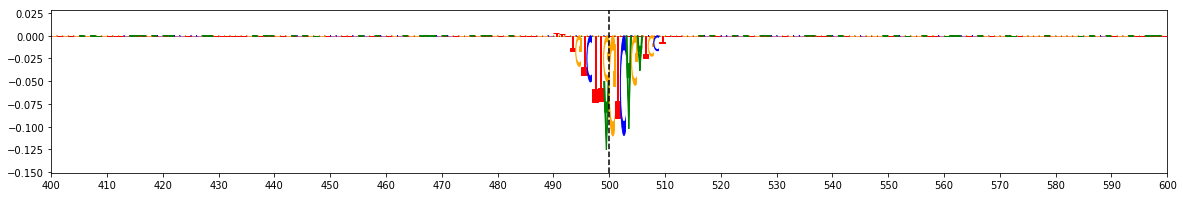


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs35577563   ||    chr19 : 45001090 - 45001091   ||    Locus: 314   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  3.70E-12
Alzheimers_Kunkle_2019 		  4.76E-09
Alzheimers_Lambert_2013 	  2.68E-09

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.6986   ||   Center / 200bp : 0.5506
Noneffect Sequence : AGAGCCCTGGCAACCTCTCG


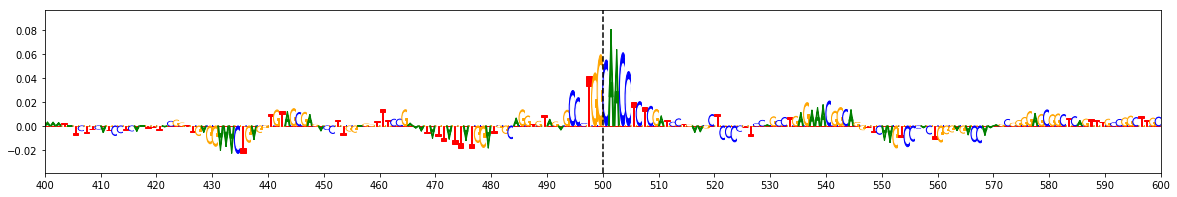

Effect Allele : C   ||   Explain Score : 0.2449   ||   Center / 200bp : 0.3011
Effect Sequence : AGAGCCCTGCCAACCTCTCG


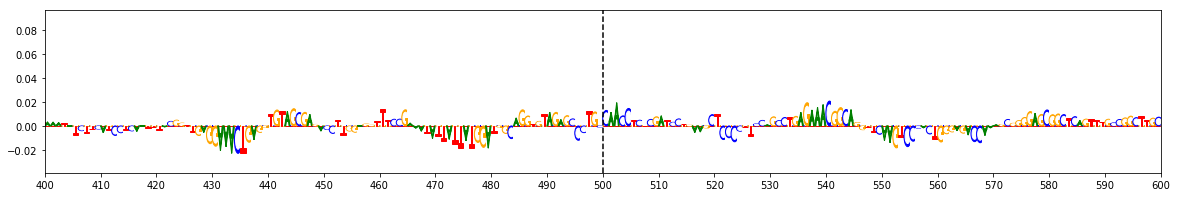

Allele Ratio : 0.3505   ||   Allele Difference : -0.4682  ||  ISM Score : -0.7314  ||  deltaSVM Score : -4.1436


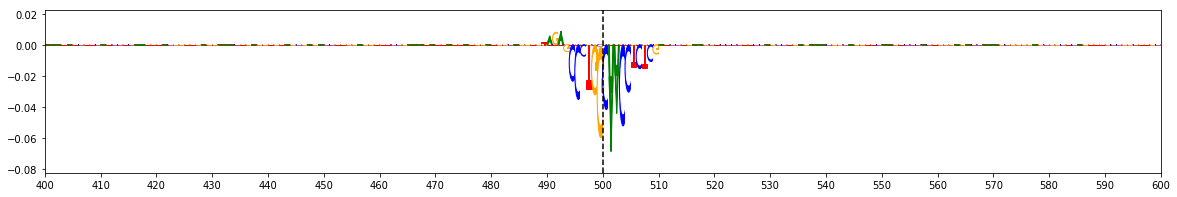


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619363   ||    chr4 : 89837895 - 89837896   ||    Locus: 451   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  1.43E-08

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 1.2251   ||   Center / 200bp : 0.5642
Noneffect Sequence : CCAATCAGCGCCTGCCAGAC


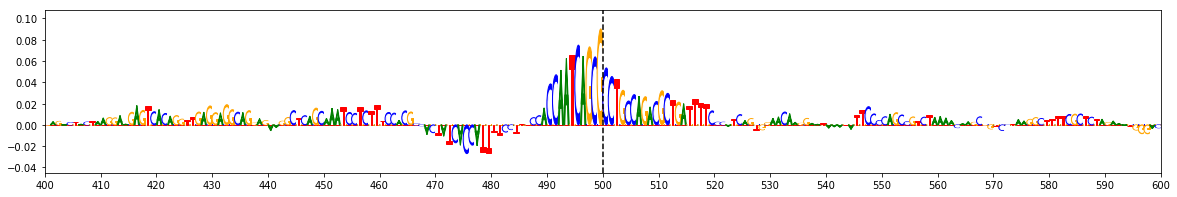

Effect Allele : NAN   ||   Explain Score : 0.4766   ||   Center / 200bp : 0.3332
Effect Sequence : CCAATCAGCCCCTGCCAGAC


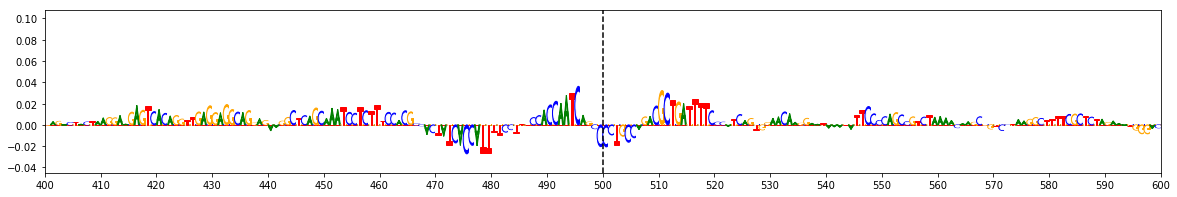

Allele Ratio : 0.389   ||   Allele Difference : -0.8661  ||  ISM Score : -1.3244  ||  deltaSVM Score : -7.8865


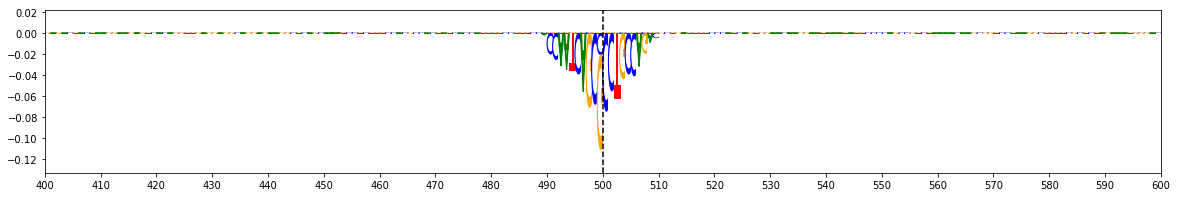


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs76594404   ||    chr17 : 45894090 - 45894091   ||    Locus: 175   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.4111   ||   Center / 200bp : 0.2558
Noneffect Sequence : CGAGGGCCGCCCACGTGGAA


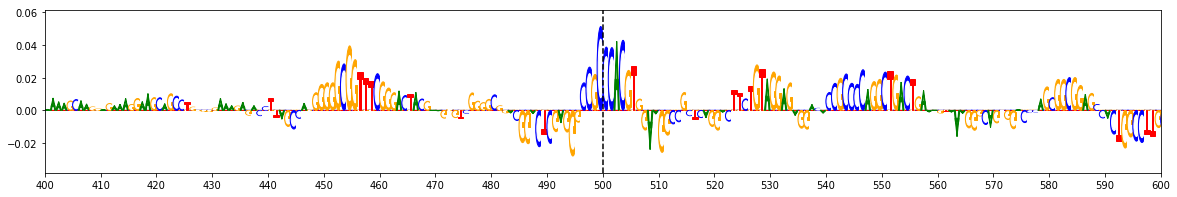

Effect Allele : G   ||   Explain Score : 0.0742   ||   Center / 200bp : 0.0582
Effect Sequence : CGAGGGCCGGCCACGTGGAA


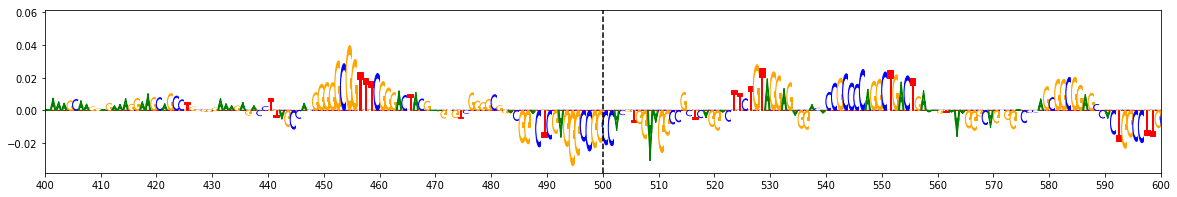

Allele Ratio : 0.1806   ||   Allele Difference : -0.5584  ||  ISM Score : -0.8706  ||  deltaSVM Score : -5.0057


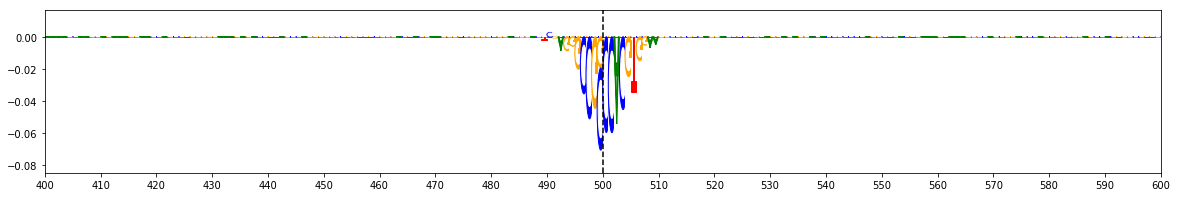


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7373790   ||    chr3 : 49053262 - 49053263   ||    Locus: 383   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  2.49E-03
Nalls_23andMe 		  2.49E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.3176   ||   Center / 200bp : 0.3558
Noneffect Sequence : CGAGGCAGGCGGATCACGAG


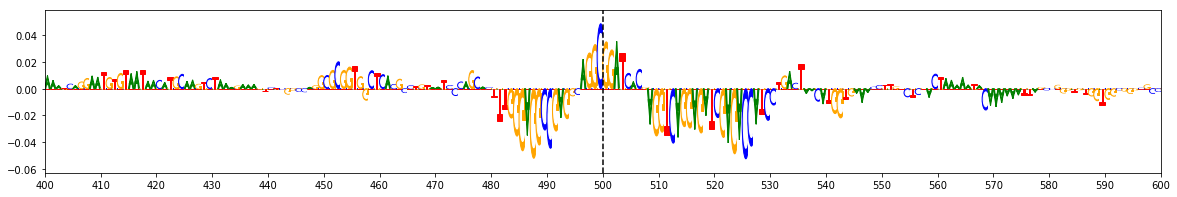

Effect Allele : T   ||   Explain Score : 0.0859   ||   Center / 200bp : 0.1303
Effect Sequence : CGAGGCAGGTGGATCACGAG


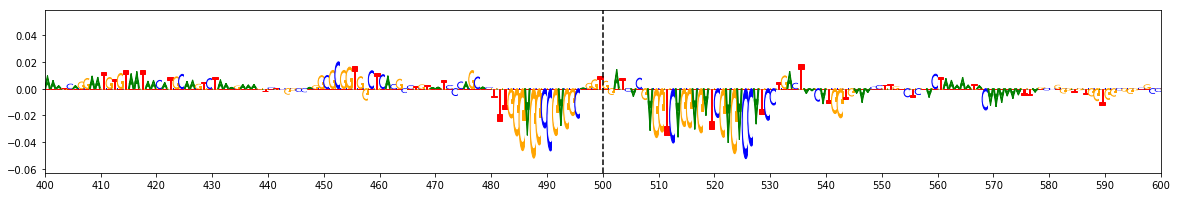

Allele Ratio : 0.2706   ||   Allele Difference : -0.3065  ||  ISM Score : -0.4863  ||  deltaSVM Score : -2.8011


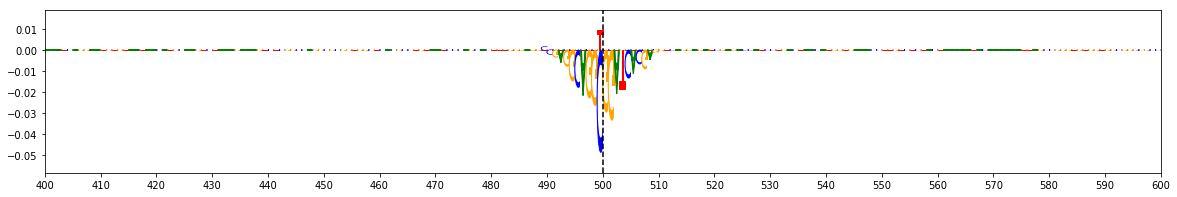


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2316952   ||    chr17 : 46061823 - 46061824   ||    Locus: 226   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.51E-22

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.8244   ||   Center / 200bp : 0.5423
Noneffect Sequence : GGCGCGGTGCCTCACGCCTG


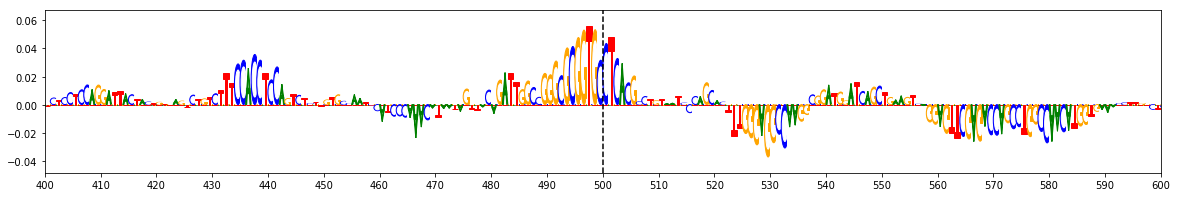

Effect Allele : G   ||   Explain Score : 0.4034   ||   Center / 200bp : 0.367
Effect Sequence : GGCGCGGTGGCTCACGCCTG


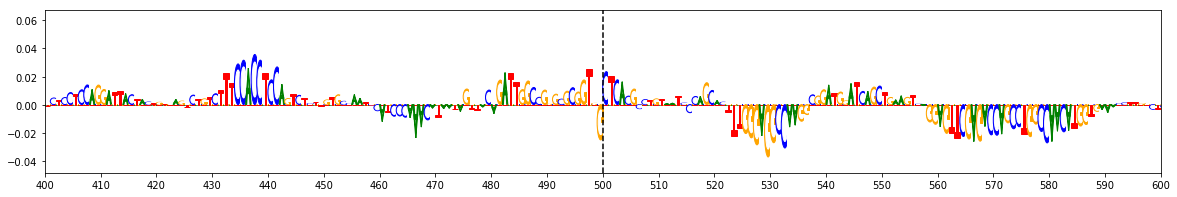

Allele Ratio : 0.4893   ||   Allele Difference : -0.4491  ||  ISM Score : -0.7022  ||  deltaSVM Score : -4.0974


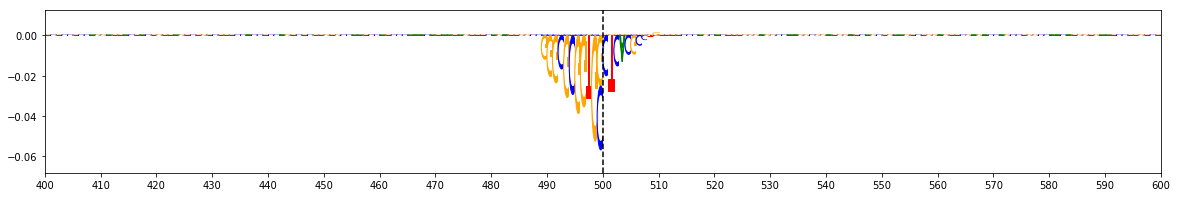


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7218117   ||    chr17 : 4842178 - 4842179   ||    Locus: 95   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  1.33E-03
Alzheimers_Lambert_2013 	  1.02E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.9542   ||   Center / 200bp : 0.6268
Noneffect Sequence : GCCTAGACCGCGCCACTGCA


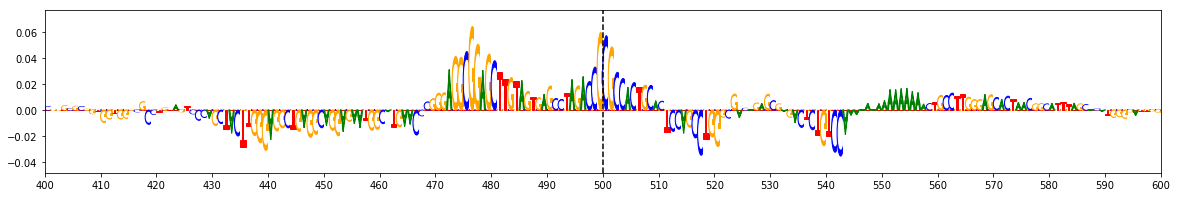

Effect Allele : A   ||   Explain Score : 0.54   ||   Center / 200bp : 0.4874
Effect Sequence : GCCTAGACCACGCCACTGCA


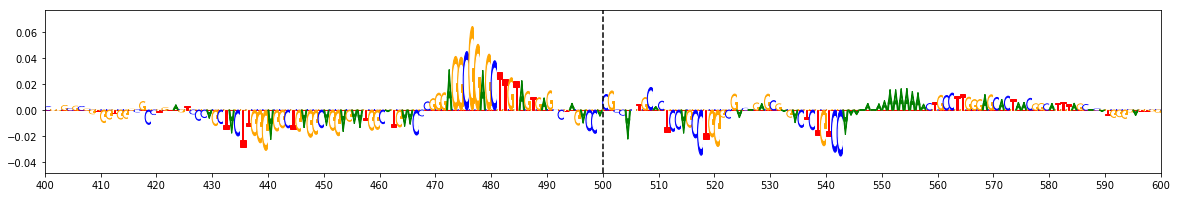

Allele Ratio : 0.566   ||   Allele Difference : -0.5106  ||  ISM Score : -0.8411  ||  deltaSVM Score : -4.8226


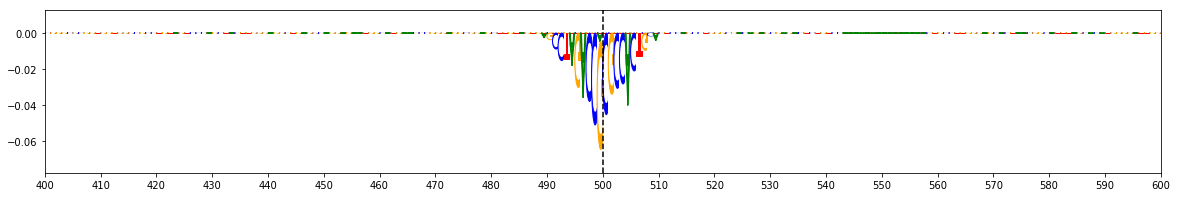


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs56118506   ||    chr3 : 122458998 - 122458999   ||    Locus: 401   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  5.45E-04

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 1.0284   ||   Center / 200bp : 0.6618
Noneffect Sequence : TTATCACTTCCGGAGGAATC


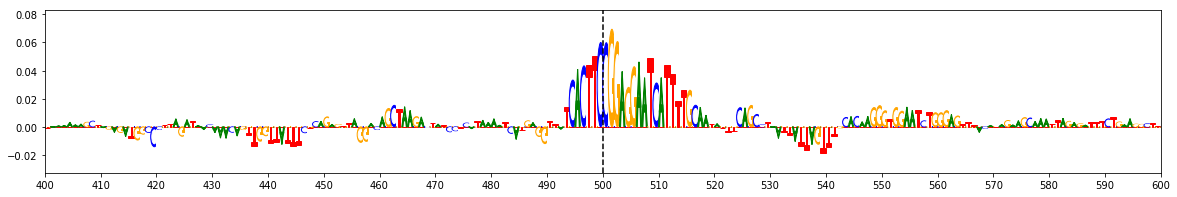

Effect Allele : T   ||   Explain Score : 0.6408   ||   Center / 200bp : 0.5496
Effect Sequence : TTATCACTTTCGGAGGAATC


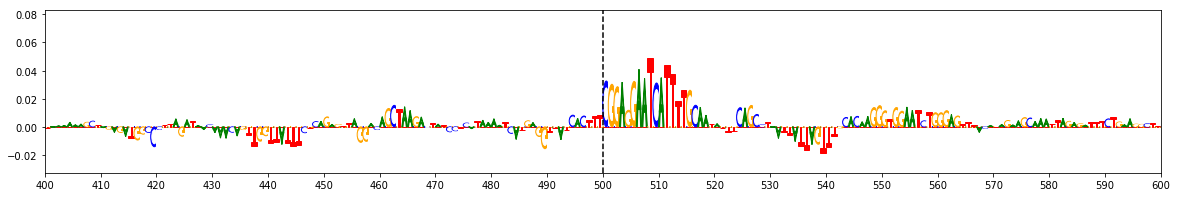

Allele Ratio : 0.6231   ||   Allele Difference : -0.4059  ||  ISM Score : -0.6325  ||  deltaSVM Score : -3.6449


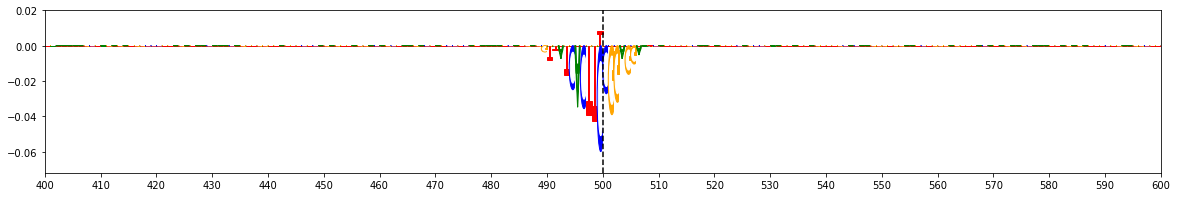


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2596407   ||    chr11 : 47340286 - 47340287   ||    Locus: 15   ||    IDR Peak: False

GWAS:
Alzheimers_Kunkle_2019 		  5.17E-08

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.7867   ||   Center / 200bp : 0.8178
Noneffect Sequence : CACACACACGCACGCGCGCA


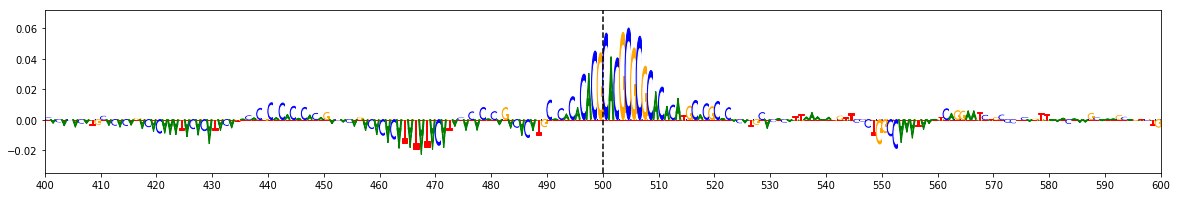

Effect Allele : A   ||   Explain Score : 0.6173   ||   Center / 200bp : 0.7898
Effect Sequence : CACACACACACACGCGCGCA


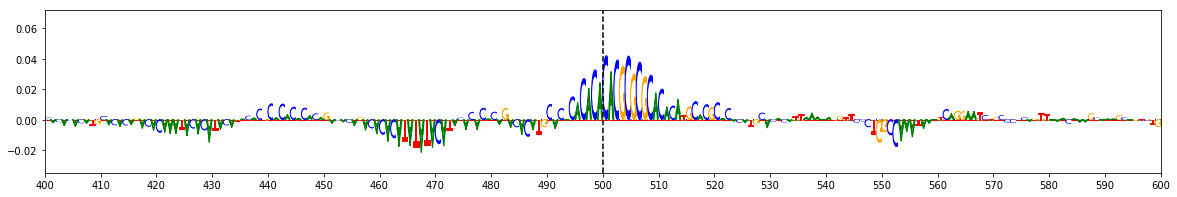

Allele Ratio : 0.7846   ||   Allele Difference : -0.1714  ||  ISM Score : -0.3822  ||  deltaSVM Score : -1.9191


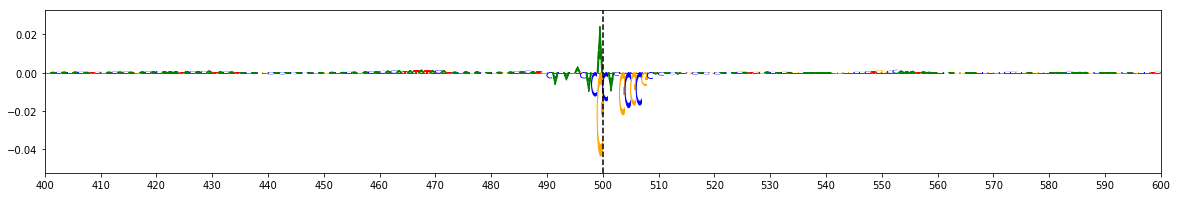


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7218130   ||    chr17 : 4842203 - 4842204   ||    Locus: 97   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  6.27E-04
Alzheimers_Lambert_2013 	  4.67E-05

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.4234   ||   Center / 200bp : 0.3232
Noneffect Sequence : GCCTGGGCGGCAGAGCGAGA


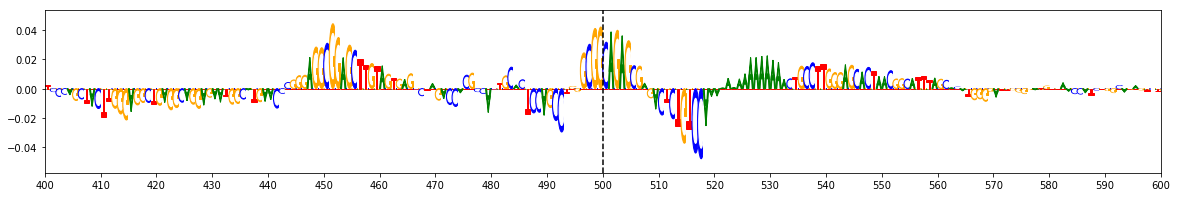

Effect Allele : A   ||   Explain Score : 0.1376   ||   Center / 200bp : 0.1342
Effect Sequence : GCCTGGGCGACAGAGCGAGA


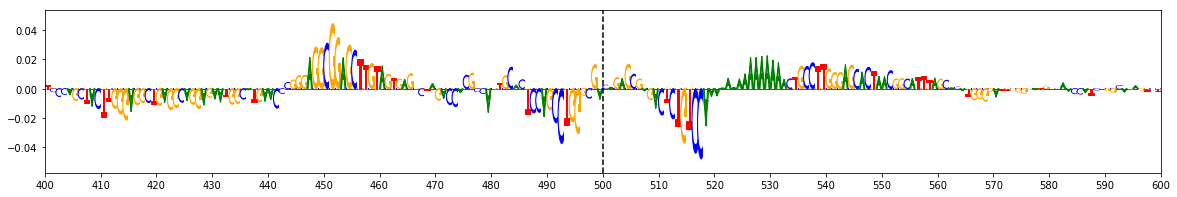

Allele Ratio : 0.3251   ||   Allele Difference : -0.3923  ||  ISM Score : -0.6717  ||  deltaSVM Score : -3.8544


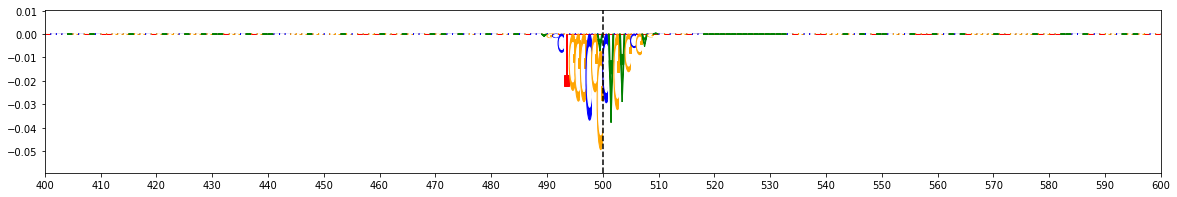


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1758631   ||    chr9 : 34024957 - 34024958   ||    Locus: 509   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.66E-01

Coloc:  False

Noneffect Allele : G   ||   Explain Score : 0.5676   ||   Center / 200bp : 0.4756
Noneffect Sequence : ACTCCAATCGGGGCGACAGA


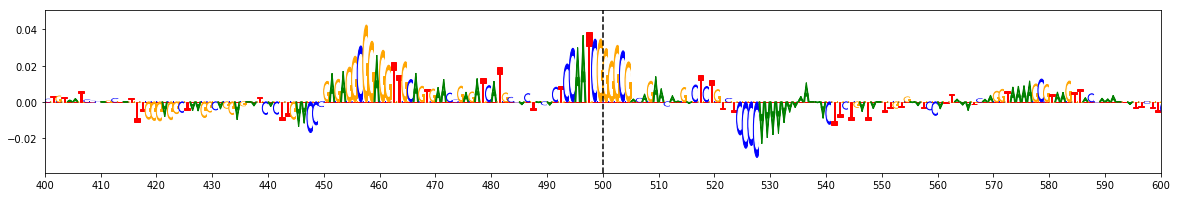

Effect Allele : T   ||   Explain Score : 0.2845   ||   Center / 200bp : 0.312
Effect Sequence : ACTCCAATCTGGGCGACAGA


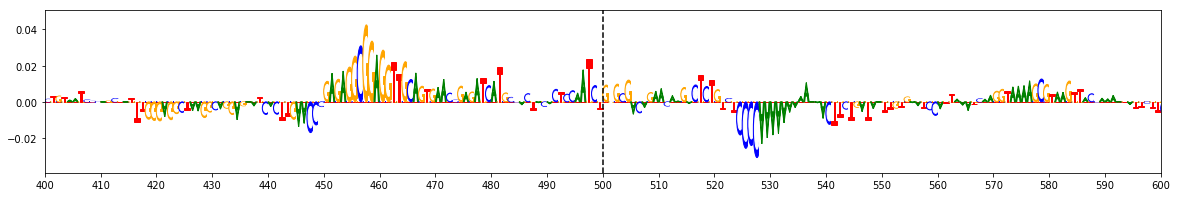

Allele Ratio : 0.5012   ||   Allele Difference : -0.3036  ||  ISM Score : -0.4858  ||  deltaSVM Score : -2.8034


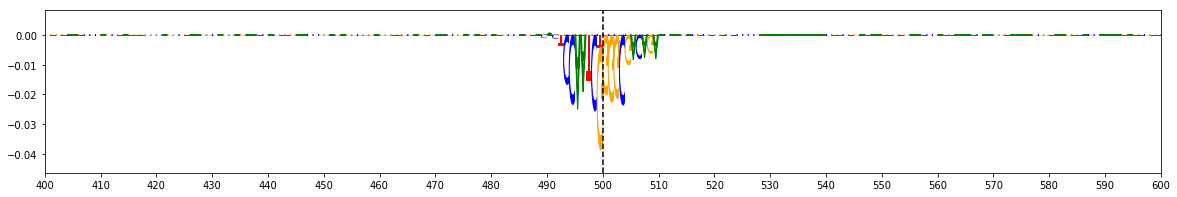


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs17788930   ||    chr11 : 47731222 - 47731223   ||    Locus: 30   ||    IDR Peak: False

GWAS:
Alzheimers_Kunkle_2019 		  2.41E-08

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.0176   ||   Center / 200bp : 0.6431
Noneffect Sequence : CCAACCATAGTAACTCATGC


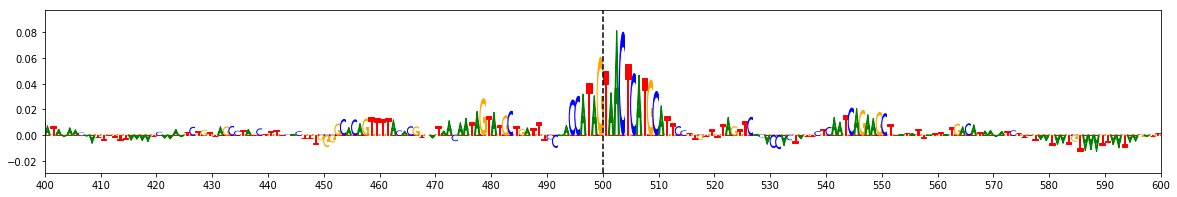

Effect Allele : A   ||   Explain Score : 0.7093   ||   Center / 200bp : 0.5566
Effect Sequence : CCAACCATAATAACTCATGC


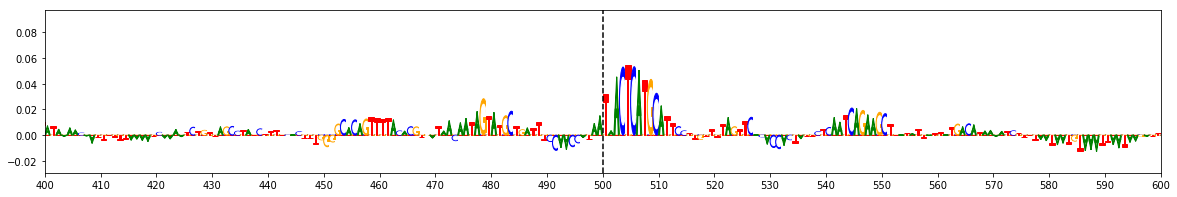

Allele Ratio : 0.697   ||   Allele Difference : -0.3542  ||  ISM Score : -0.5565  ||  deltaSVM Score : -3.192


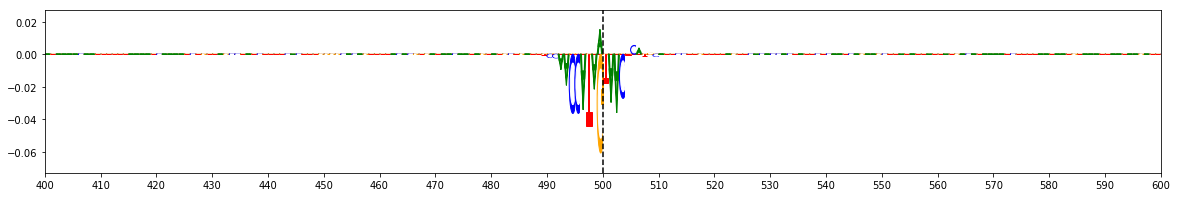


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10426401   ||    chr19 : 44644418 - 44644419   ||    Locus: 282   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.63E-14
Alzheimers_Kunkle_2019 		  5.66E-11
Alzheimers_Lambert_2013 	  2.79E-09

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.8039   ||   Center / 200bp : 0.443
Noneffect Sequence : CAACACGGGGCGGGCACAAG


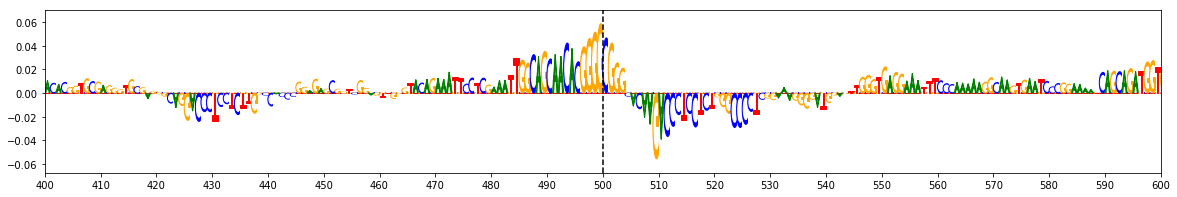

Effect Allele : T   ||   Explain Score : 0.3918   ||   Center / 200bp : 0.2789
Effect Sequence : CAACACGGGTCGGGCACAAG


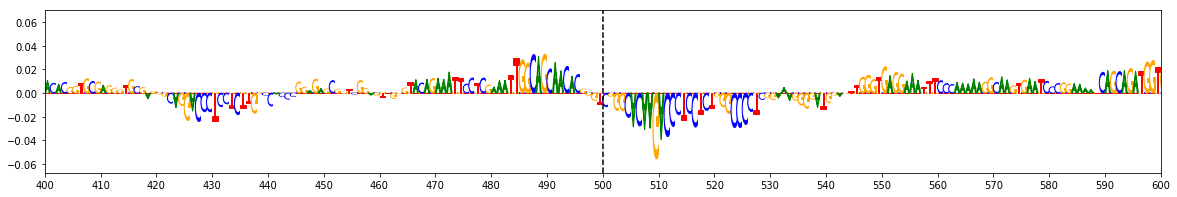

Allele Ratio : 0.4874   ||   Allele Difference : -0.5385  ||  ISM Score : -0.8585  ||  deltaSVM Score : -4.9264


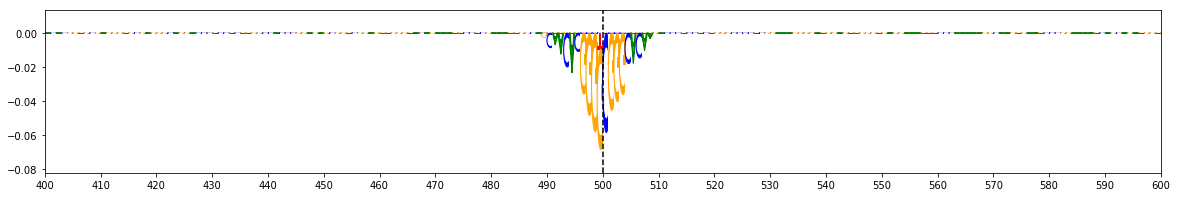


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6881225   ||    chr5 : 102971887 - 102971888   ||    Locus: 457   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.13E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 2.7508   ||   Center / 200bp : 0.7506
Noneffect Sequence : TGTAAGAGACAGCCATCTAG


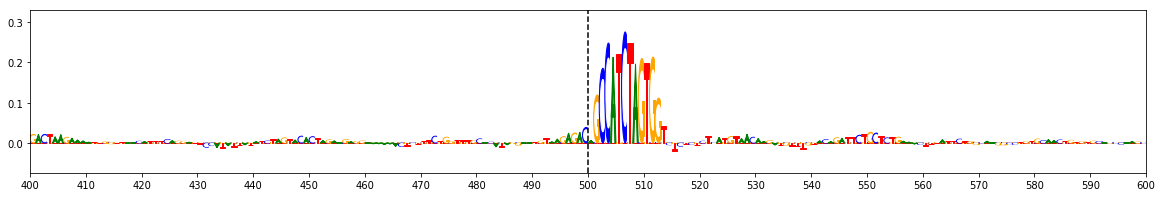

Effect Allele : T   ||   Explain Score : 2.3185   ||   Center / 200bp : 0.7174
Effect Sequence : TGTAAGAGATAGCCATCTAG


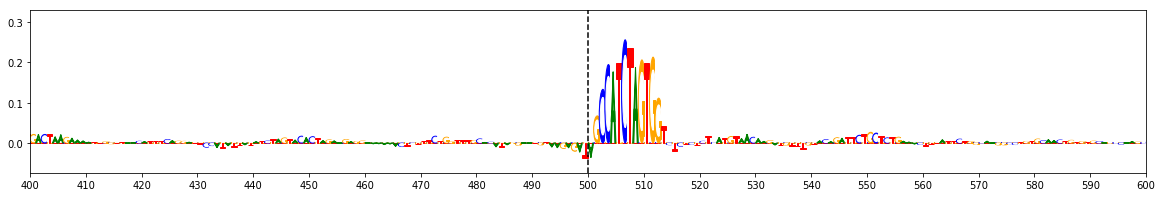

Allele Ratio : 0.8429   ||   Allele Difference : -0.6005  ||  ISM Score : -0.9406  ||  deltaSVM Score : -5.3568


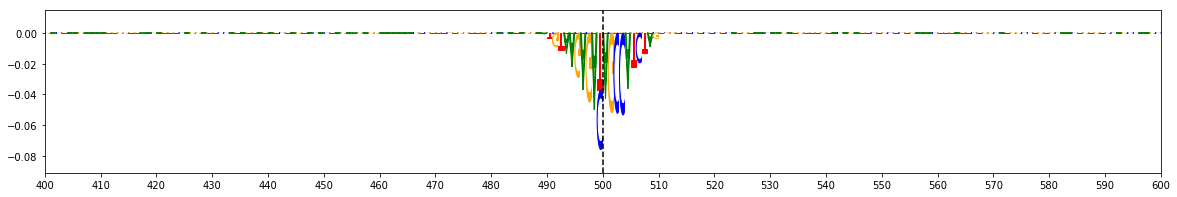


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs118039704   ||    chr17 : 62065536 - 62065537   ||    Locus: 246   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.70E-04

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.2104   ||   Center / 200bp : 0.2109
Noneffect Sequence : GACGGAGGGAATGTGTGCCC


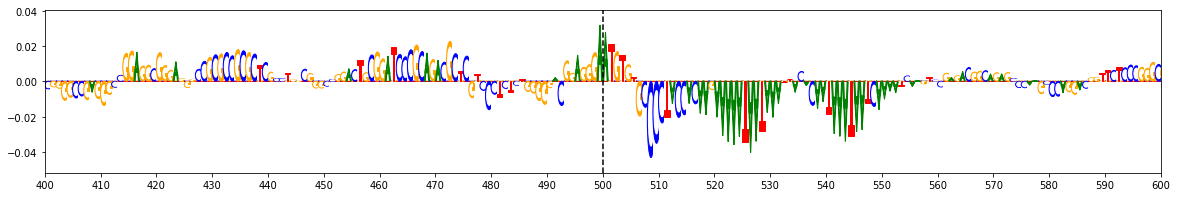

Effect Allele : G   ||   Explain Score : 0.05   ||   Center / 200bp : 0.0599
Effect Sequence : GACGGAGGGGATGTGTGCCC


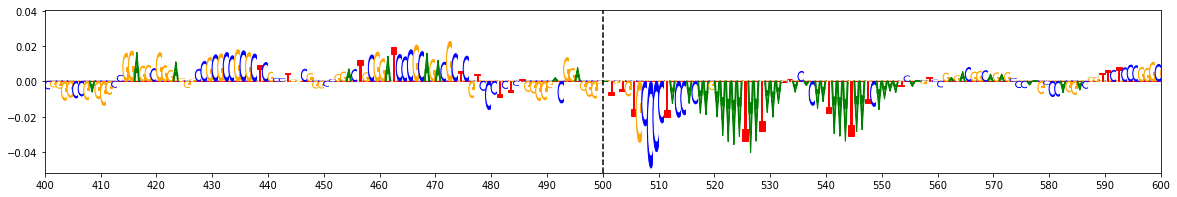

Allele Ratio : 0.2378   ||   Allele Difference : -0.2597  ||  ISM Score : -0.42  ||  deltaSVM Score : -2.391


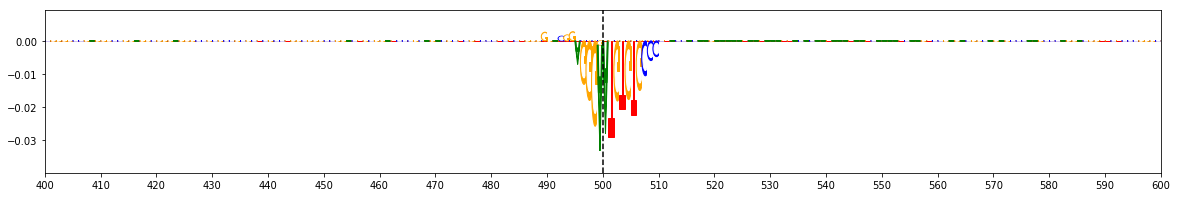


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs17839568   ||    chr16 : 31088461 - 31088462   ||    Locus: 86   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  2.03E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 1.3087   ||   Center / 200bp : 0.6364
Noneffect Sequence : CTGACGTCACTGTGGAAGTC


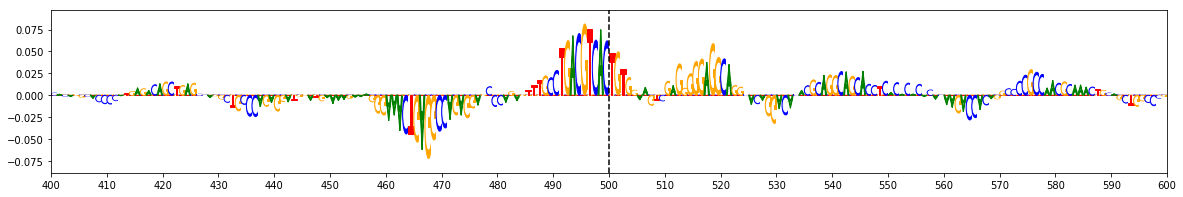

Effect Allele : T   ||   Explain Score : 0.9555   ||   Center / 200bp : 0.5609
Effect Sequence : CTGACGTCATTGTGGAAGTC


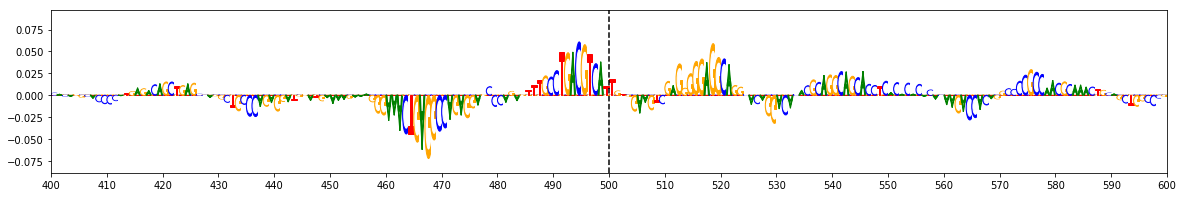

Allele Ratio : 0.7301   ||   Allele Difference : -0.4061  ||  ISM Score : -0.6397  ||  deltaSVM Score : -3.6788


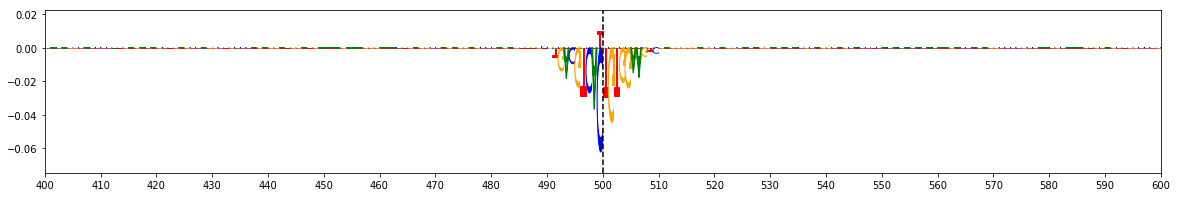


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62055934   ||    chr17 : 45771271 - 45771272   ||    Locus: 156   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.71E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 1.3084   ||   Center / 200bp : 0.6773
Noneffect Sequence : GGATATGACAGGATATGAGG


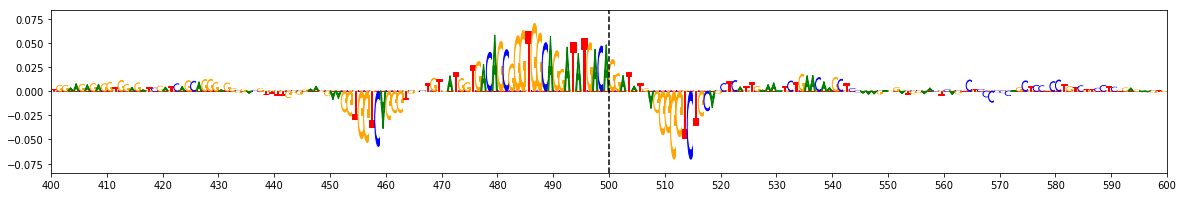

Effect Allele : G   ||   Explain Score : 1.0373   ||   Center / 200bp : 0.6237
Effect Sequence : GGATATGACGGGATATGAGG


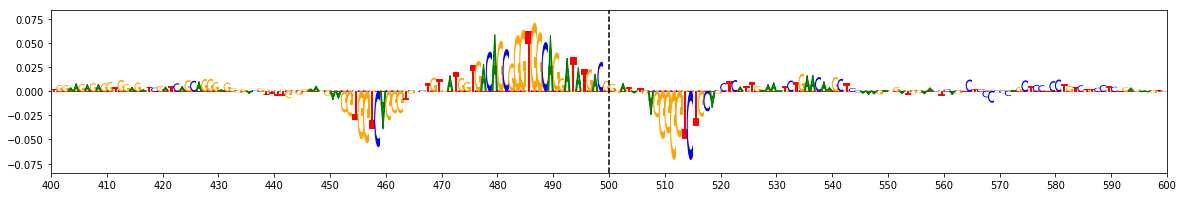

Allele Ratio : 0.7928   ||   Allele Difference : -0.2928  ||  ISM Score : -0.4479  ||  deltaSVM Score : -2.7238


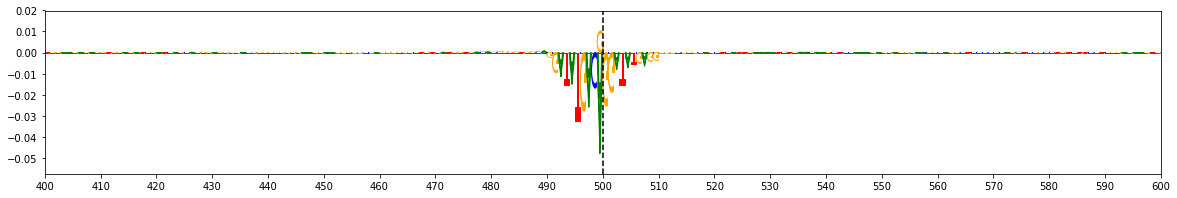


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79589869   ||    chr17 : 45852871 - 45852872   ||    Locus: 172   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.11E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 3.4839   ||   Center / 200bp : 0.832
Noneffect Sequence : TTGAATGCTACTGTGCTGCC


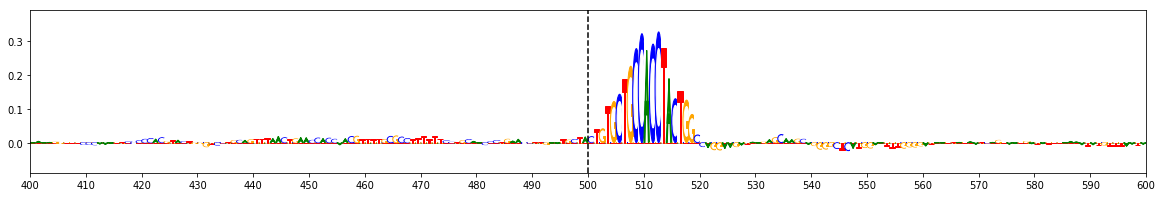

Effect Allele : C   ||   Explain Score : 3.4674   ||   Center / 200bp : 0.8313
Effect Sequence : TTGAATGCTCCTGTGCTGCC


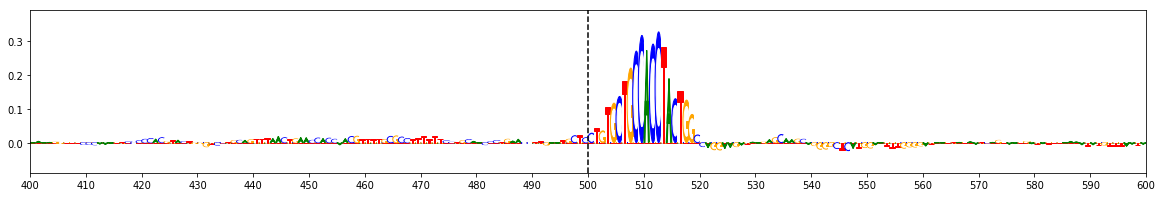

Allele Ratio : 0.9953   ||   Allele Difference : -0.0192  ||  ISM Score : -0.0303  ||  deltaSVM Score : -0.1977


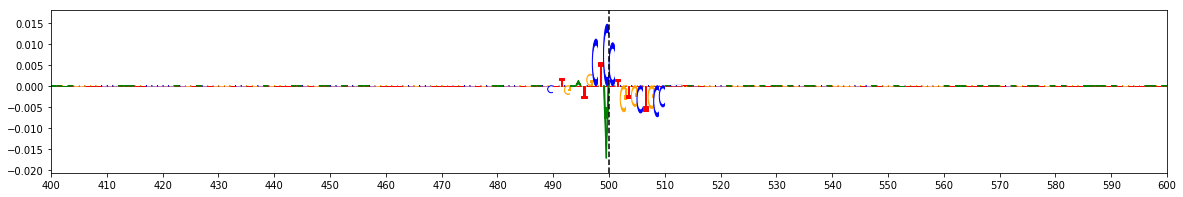


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11575896   ||    chr17 : 45894775 - 45894776   ||    Locus: 180   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.6935   ||   Center / 200bp : 0.4754
Noneffect Sequence : GCAGACTGGAGCTTCGTGCG


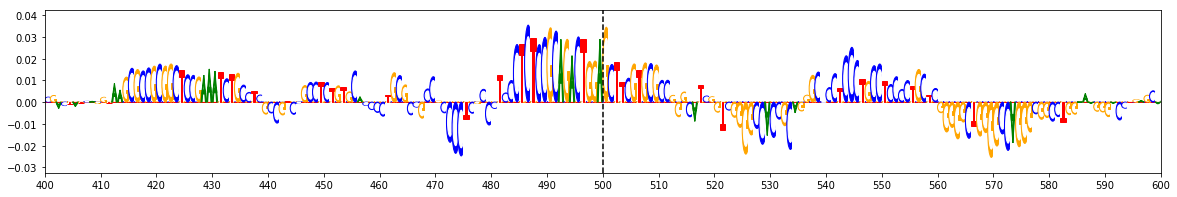

Effect Allele : G   ||   Explain Score : 0.3952   ||   Center / 200bp : 0.3407
Effect Sequence : GCAGACTGGGGCTTCGTGCG


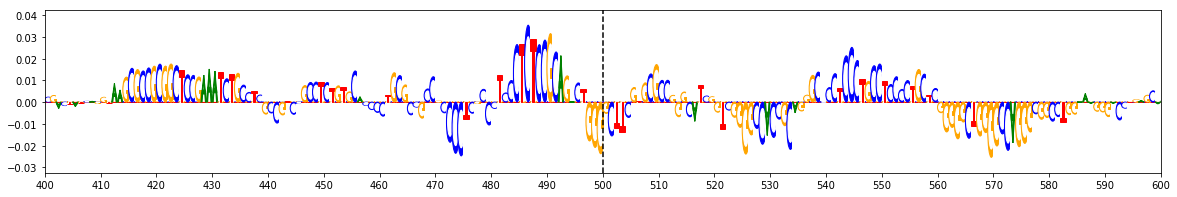

Allele Ratio : 0.5698   ||   Allele Difference : -0.4139  ||  ISM Score : -0.6647  ||  deltaSVM Score : -3.8179


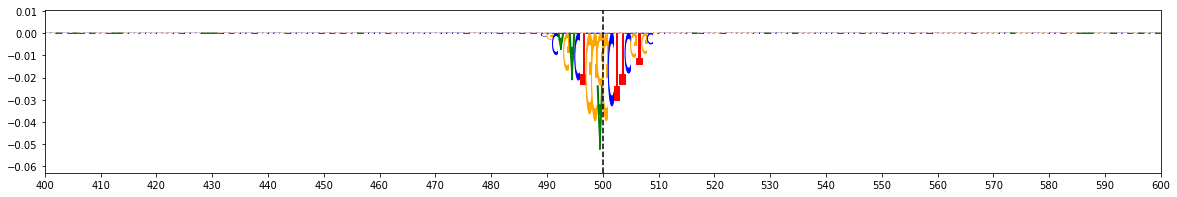


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs413778   ||    chr17 : 45639518 - 45639519   ||    Locus: 134   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.96E-22
Parkinsons_Pankratz_2012 	  2.17E-10

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.7527   ||   Center / 200bp : 0.5548
Noneffect Sequence : GGTGAGTCAGAGTAAGTATA


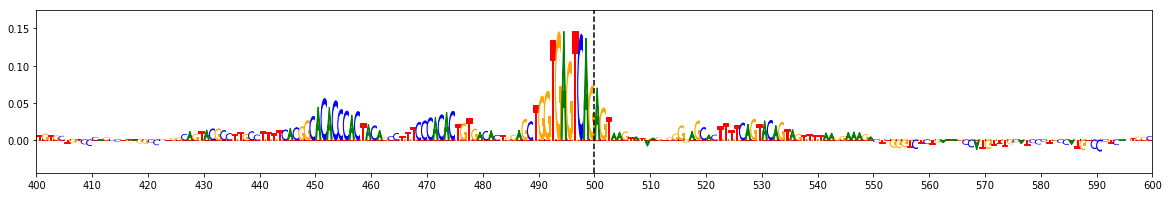

Effect Allele : A   ||   Explain Score : 1.1794   ||   Center / 200bp : 0.4561
Effect Sequence : GGTGAGTCAAAGTAAGTATA


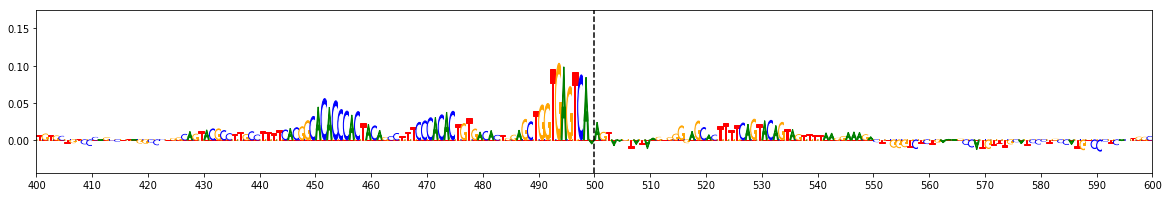

Allele Ratio : 0.6729   ||   Allele Difference : -0.6146  ||  ISM Score : -0.9573  ||  deltaSVM Score : -5.5925


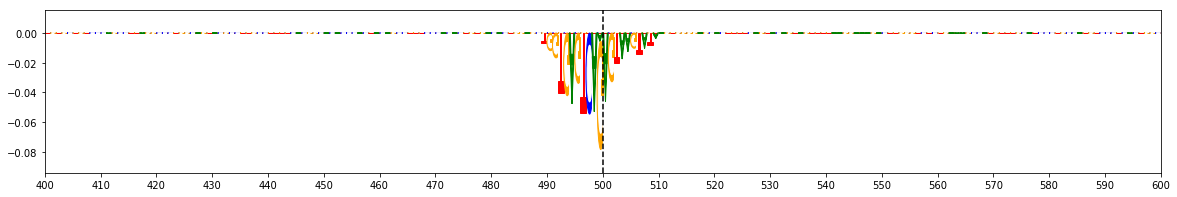


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [6]:
for idx in neg_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], ':', neg_snps.at[idx, 'start'], '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in neg_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
    
    print("Coloc: ", neg_snps.at[idx, 'coloc'])
    
    print()
    
    print('Noneffect Allele :', neg_snps.at[idx, 'noneffect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'noneffect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence :', noneffect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Effect Allele :', neg_snps.at[idx, 'effect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'effect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence :', effect_seqs[idx][490:510])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(neg_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(neg_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(neg_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(neg_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()

## Find Non-Effect Alleles that Improve Accessibility <a name='noneffect_table' />

In [7]:
pos_snps = snps.loc[snps['allele_ratio'] > 1]
pos_snps.sort_values(by=['effect_rank'], ascending=False, inplace=True)
display(pos_snps)

chr      start        end         rsid effect noneffect ref  alt major  \
211  chr17   46003041   46003042  17_46003042      G         C   .    .     .   
140  chr17   45703883   45703884     rs968027      T         C   C    T     C   
374   chr3   18177544   18177545    rs4688901      G         A   G    A     G   
189  chr17   45896863   45896864   rs62056782      T         C   C    T     C   
171  chr17   45852666   45852667   rs62054825      G         A   G    A     G   
10   chr10   80493944   80493945    rs7900536      A         C   C  A,T     A   
393   chr3   52498433   52498434  rs181391313      G         A   G    A     G   
81   chr16   31009756   31009757    rs7184567      T         C   C    T     C   
318  chr19   45039212   45039213   rs34034621      T         C   C    T     C   
429   chr4   89762970   89762971   rs34806123      G         A   A    G     A   
363   chr2  233146226  233146227    rs1135173      A         G   G  A,T     G   
217  chr17   46038519   46038520   rs12150090      T         C   C  G,T     C   
463   chr5  103224361  103224362     rs152137      T         C   C    T     C   
13   chr10  102245652  102245653    rs2296887      T         C   T    C     T   
77   chr16   30941880   30941881    rs1458202      G         A   G  A,C     A   
82   chr16   31011317   31011318   rs72800847      G         A   G    A     G   
294  chr19   44911193   44911194     rs439401      T         C   T    C     C   
191  chr17   45897109   45897110   rs80346216      T         G   G    T     G   
467   chr5  134594466  134594467  rs113661575      G         C   G  A,C     G   
431   chr4   89765967   89765968    rs3775427      G         A   G    A     G   
369  chr20    6030475    6030476    rs6053835      G         A   A    G     A   
344   chr2  127084806  127084807   rs11691237      T         C   C    T     C   
354   chr2  134712198  134712199    rs6747870      G         A   A    G     A   
430   chr4   89762971   89762972   rs35495602      G         A   A    G     A   
243  chr17   46771150   46771151     rs199523      C         A   C    A     A   
228  chr17   46093245   46093246   rs17660398      T         C   C    T     C   
456   chr5  102959365  102959366    rs3776870      G         A   G    A     G   
412   chr4     987143     987144   rs10902762      G         A   G    A     G   
359   chr2  134718389  134718390   rs62171393      G         C   C    G     C   
24   chr11   47418731   47418732    rs2293580      A         T   T  A,G     A   
..     ...        ...        ...          ...    ...       ...  ..  ...   ...   
388   chr3   52339932   52339933  rs149814394      G         A   G    A     G   
250  chr17   75011885   75011886   rs35303667      A         T   T    A     T   
462   chr5  103120599  103120600      rs26524      G         A   A    G     A   
507   chr9   33957503   33957504     rs668071      C         A   A    C     A   
213  chr17   46028853   46028854   rs79772576      G         A   A    G     A   
303  chr19   44955208   44955209  rs143674704      A         G   A    G     A   
190  chr17   45896987   45896988  rs113161176      G         A   G    A     G   
75   chr16   30931303   30931304   rs10782001      G         A   G    A     A   
65   chr14   67515536   67515537    rs7154258      T         G   G    T     G   
409   chr4     973656     973657   rs13137144      G         A   G  A,C     G   
472   chr6   27762284   27762285    rs9295746      T         C   T    C     T   
193  chr17   45897182   45897183   rs62056783      G         C   G    C     G   
373  chr21   37452656   37452657   rs11088398      T         G   G    T     G   
498   chr8   27610303   27610304    rs2070926      C         G   C    G     G   
187  chr17   45896131   45896132    rs4792891      T         G   T    G     T   
459   chr5  102998542  102998543   rs62362544      T         C   C    T     C   
333  chr19   45187781   45187782   rs12463106      T         G   G    T     G   
136  chr17   45667623   45667624   rs1

## Visualize Top Non-Effect Alleles <a name='noneffect_viz' />

RSID: 17_46003042   ||    chr17 : 46003041 - 46003042   ||    Locus: 211   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.18E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.2879   ||  Center / 200bp: 0.2301
Effect Sequence: CTCAGCCTCGCAAATTGCTG


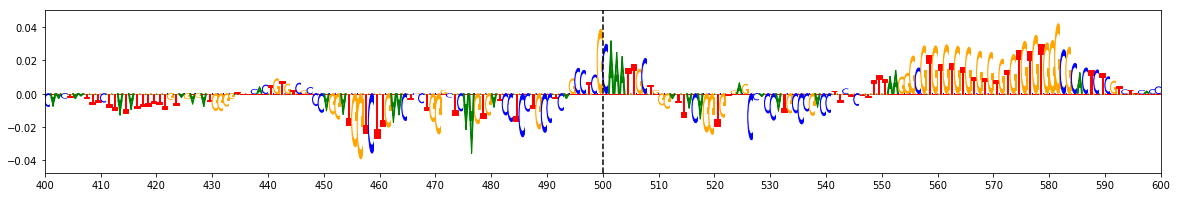

Noneffect Allele: C   ||  Explain Score: 0.0255   ||  Center / 200bp: 0.0259
Noneffect Sequence: CTCAGCCTCCCAAATTGCTG


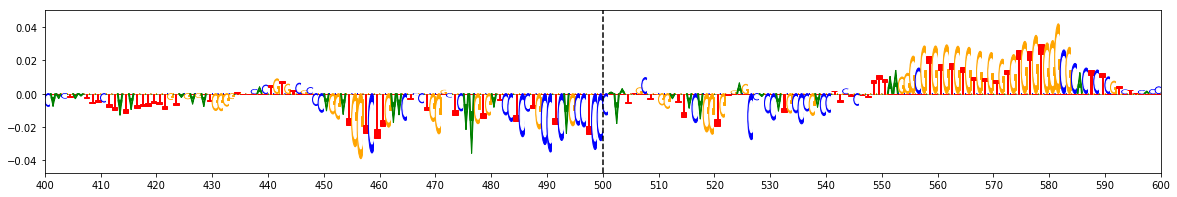

Allele Ratio : 11.2714   ||   Allele Difference : 0.526  ||  ISM Score : 0.9043  ||  deltaSVM Score : 5.2425


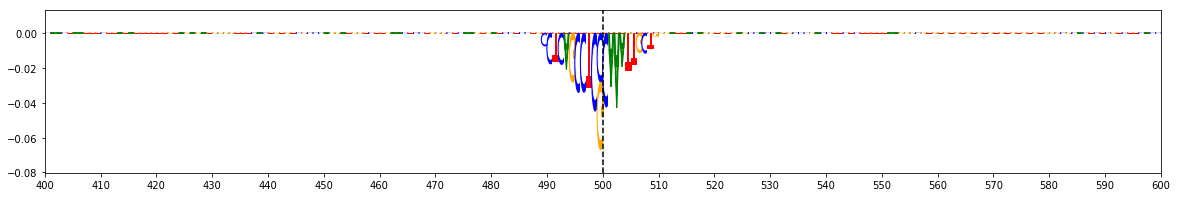


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs968027   ||    chr17 : 45703883 - 45703884   ||    Locus: 140   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.07E-22
Parkinsons_Pankratz_2012 	  2.99E-10

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.3594   ||  Center / 200bp: 0.2796
Effect Sequence: ATCCCTGACTAACCTGATGT


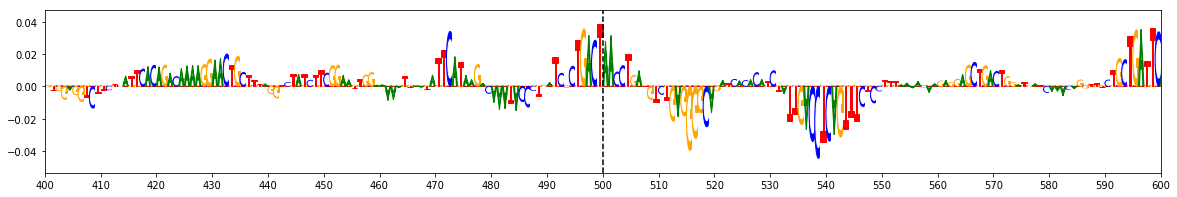

Noneffect Allele: C   ||  Explain Score: 0.0471   ||  Center / 200bp: 0.0483
Noneffect Sequence: ATCCCTGACCAACCTGATGT


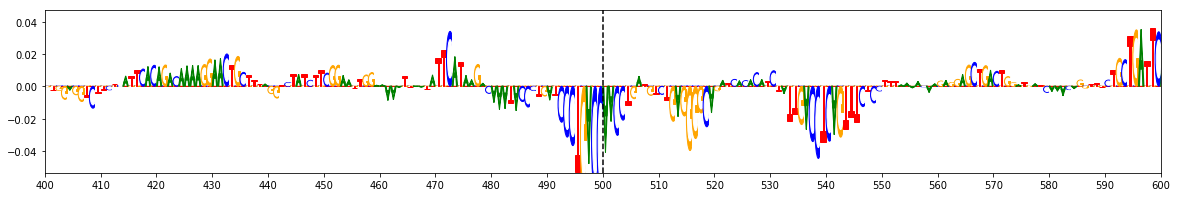

Allele Ratio : 7.6367   ||   Allele Difference : 0.8513  ||  ISM Score : 1.326  ||  deltaSVM Score : 7.6465


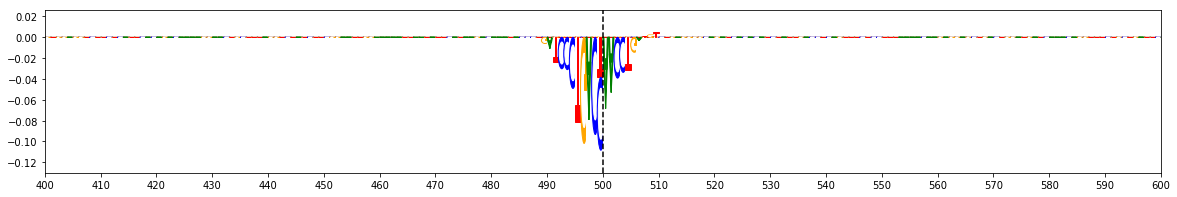


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs4688901   ||    chr3 : 18177544 - 18177545   ||    Locus: 374   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  4.74E-05

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.6092   ||  Center / 200bp: 0.3696
Effect Sequence: TCTAGGGGCGTGGTAATGTT


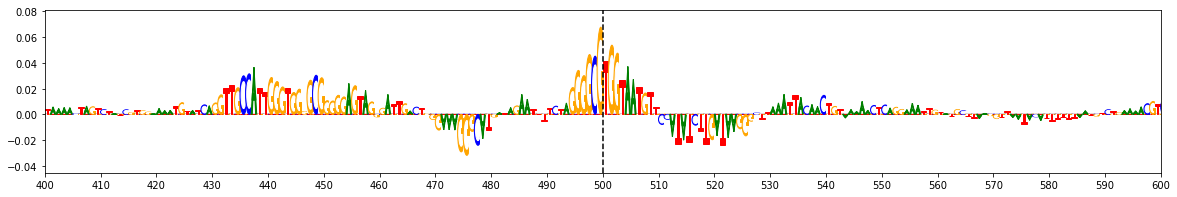

Noneffect Allele: A   ||  Explain Score: 0.1583   ||  Center / 200bp: 0.1323
Noneffect Sequence: TCTAGGGGCATGGTAATGTT


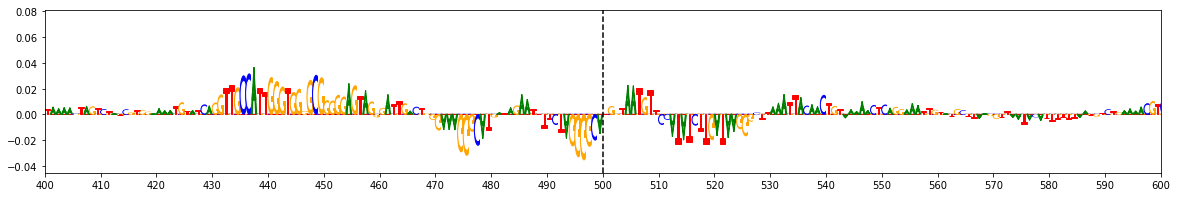

Allele Ratio : 3.8483   ||   Allele Difference : 0.6522  ||  ISM Score : 1.0213  ||  deltaSVM Score : 5.8847


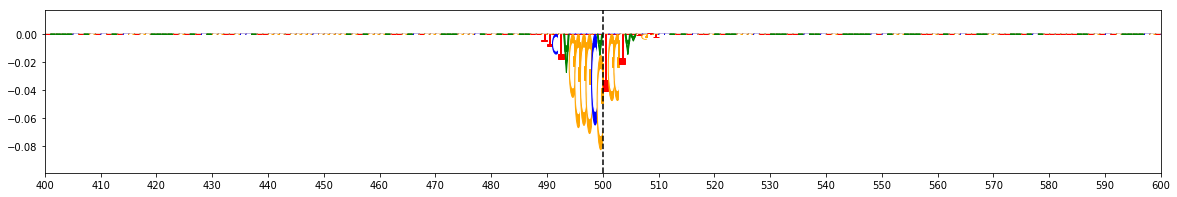


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62056782   ||    chr17 : 45896863 - 45896864   ||    Locus: 189   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.9576   ||  Center / 200bp: 0.6575
Effect Sequence: CTCGCCCTCTTGTGATGAAC


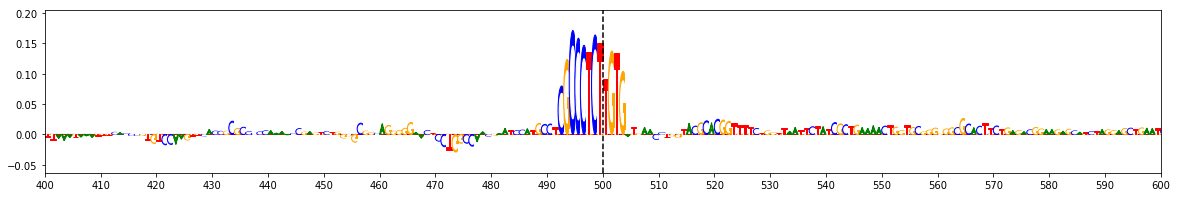

Noneffect Allele: C   ||  Explain Score: 0.9375   ||  Center / 200bp: 0.4791
Noneffect Sequence: CTCGCCCTCCTGTGATGAAC


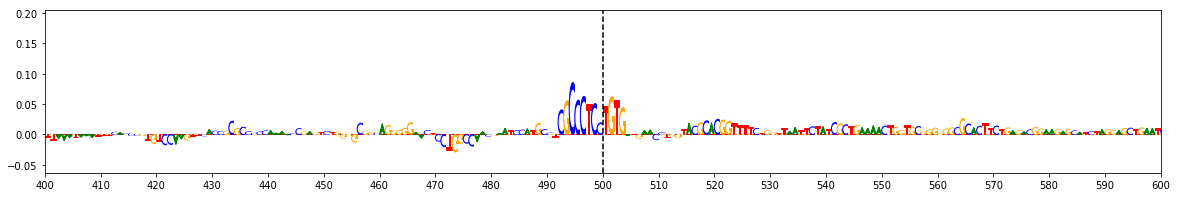

Allele Ratio : 2.088   ||   Allele Difference : 1.0289  ||  ISM Score : 1.6065  ||  deltaSVM Score : 9.2644


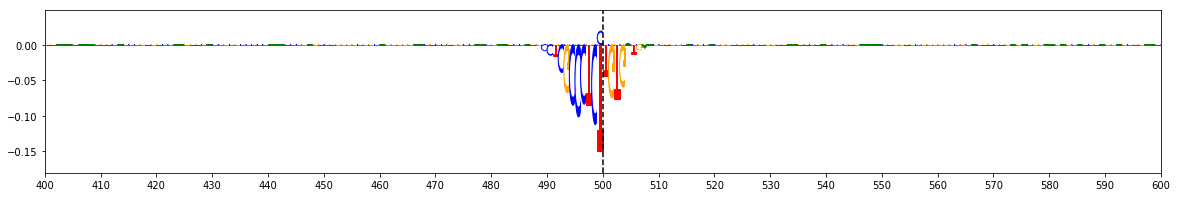


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62054825   ||    chr17 : 45852666 - 45852667   ||    Locus: 171   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.25E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 1.5881   ||  Center / 200bp: 0.5919
Effect Sequence: TGAGCTCCCGGAAGTGGAGT


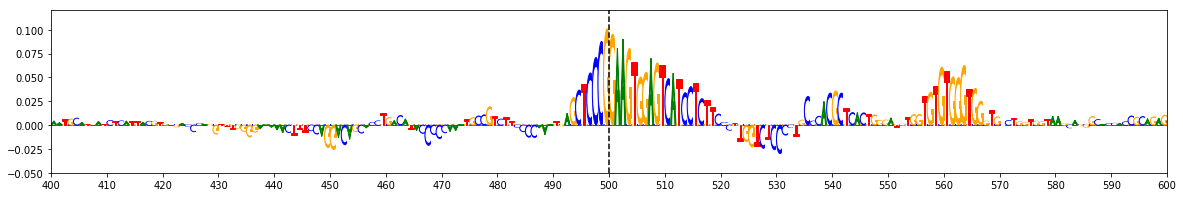

Noneffect Allele: A   ||  Explain Score: 0.7305   ||  Center / 200bp: 0.4
Noneffect Sequence: TGAGCTCCCAGAAGTGGAGT


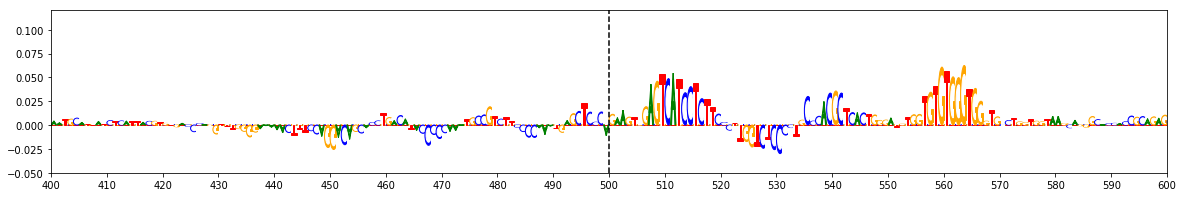

Allele Ratio : 2.1741   ||   Allele Difference : 0.8803  ||  ISM Score : 1.378  ||  deltaSVM Score : 7.914


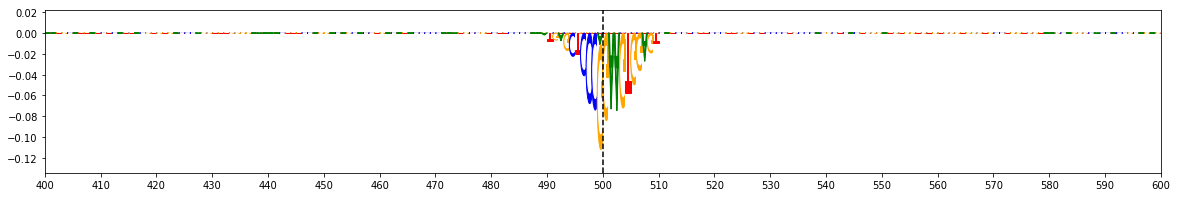


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7900536   ||    chr10 : 80493944 - 80493945   ||    Locus: 10   ||    IDR Peak: False

GWAS:
Alzheimers_Kunkle_2019 		  2.91E-05

Coloc:  True

Effect Allele: A   ||  Explain Score: 2.2477   ||  Center / 200bp: 0.7575
Effect Sequence: GGATGATTCAGATAATGTCT


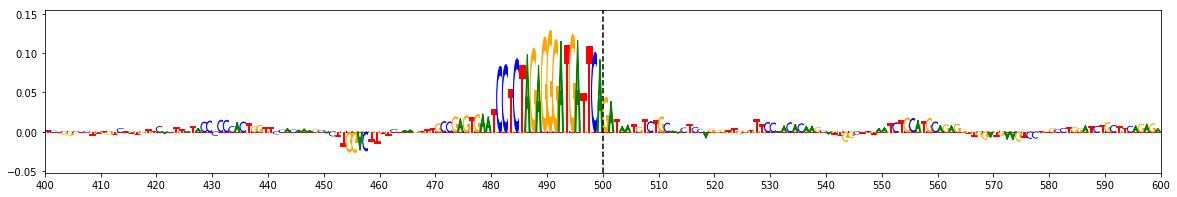

Noneffect Allele: C   ||  Explain Score: 1.504   ||  Center / 200bp: 0.6762
Noneffect Sequence: GGATGATTCCGATAATGTCT


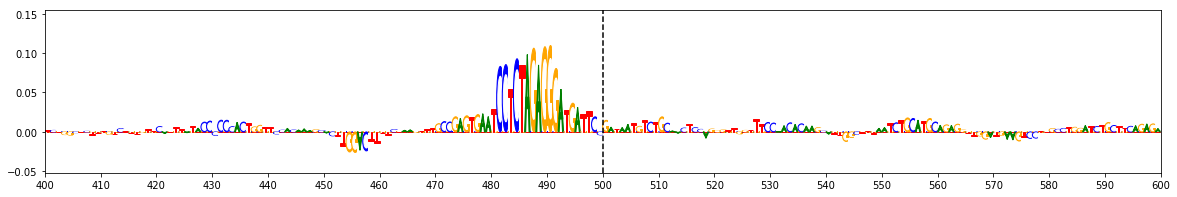

Allele Ratio : 1.4945   ||   Allele Difference : 0.7475  ||  ISM Score : 1.1629  ||  deltaSVM Score : 6.9102


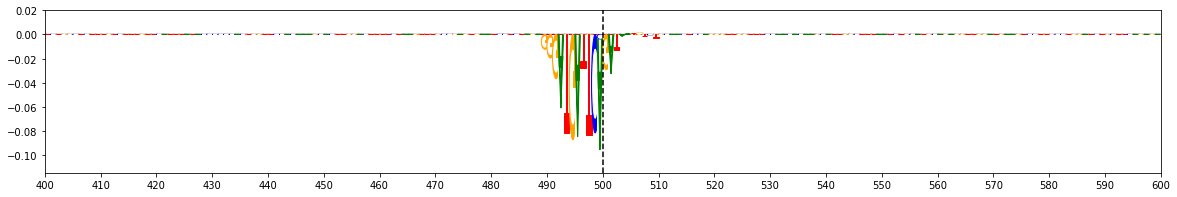


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs181391313   ||    chr3 : 52498433 - 52498434   ||    Locus: 393   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  2.73E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.4138   ||  Center / 200bp: 0.2681
Effect Sequence: CCATGGGGCGGAGGCAGGGC


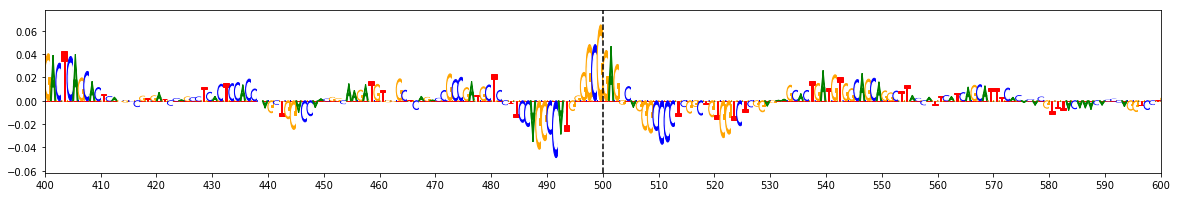

Noneffect Allele: A   ||  Explain Score: 0.1021   ||  Center / 200bp: 0.0829
Noneffect Sequence: CCATGGGGCAGAGGCAGGGC


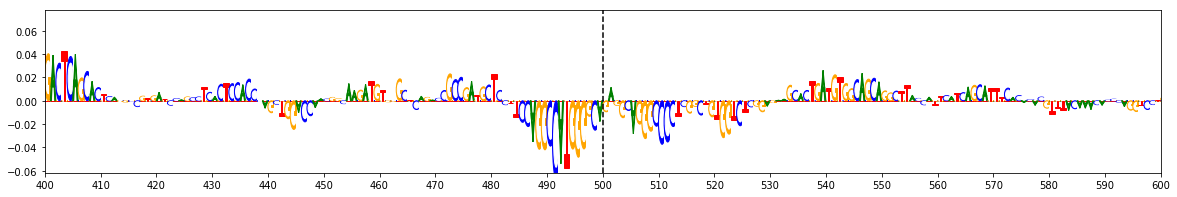

Allele Ratio : 4.0518   ||   Allele Difference : 0.6529  ||  ISM Score : 1.021  ||  deltaSVM Score : 5.8907


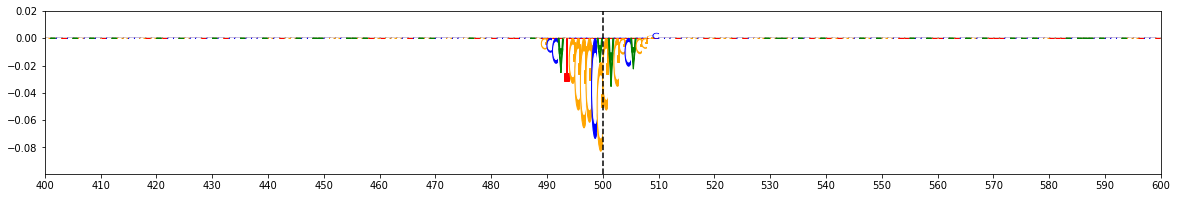


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7184567   ||    chr16 : 31009756 - 31009757   ||    Locus: 81   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  2.10E-04

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.3726   ||  Center / 200bp: 0.4806
Effect Sequence: TCTGCATCCTCATCTCCCAC


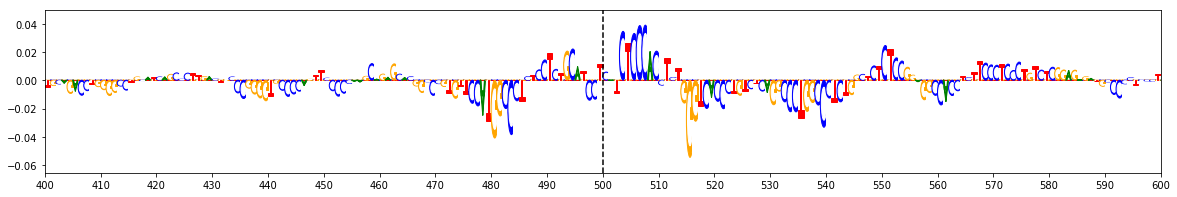

Noneffect Allele: C   ||  Explain Score: 0.1678   ||  Center / 200bp: 0.2944
Noneffect Sequence: TCTGCATCCCCATCTCCCAC


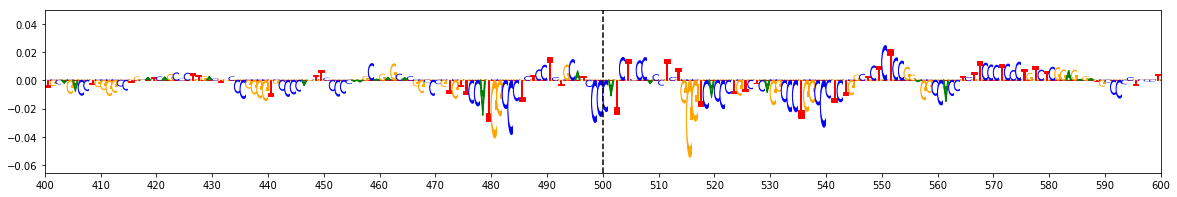

Allele Ratio : 2.2198   ||   Allele Difference : 0.2906  ||  ISM Score : 0.4643  ||  deltaSVM Score : 2.7429


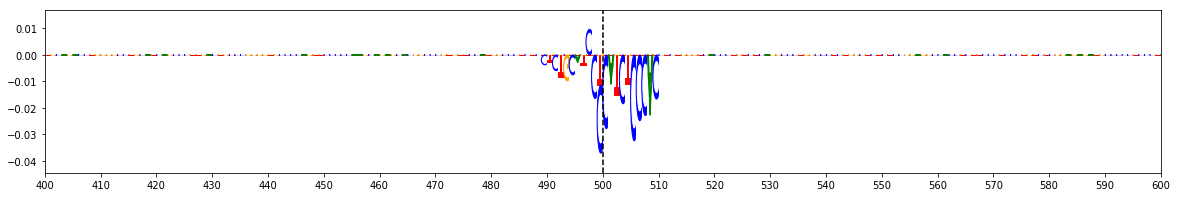


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs34034621   ||    chr19 : 45039212 - 45039213   ||    Locus: 318   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.19E-08

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.7348   ||  Center / 200bp: 0.6769
Effect Sequence: CTGCTGCGTTCCGGCCCCGA


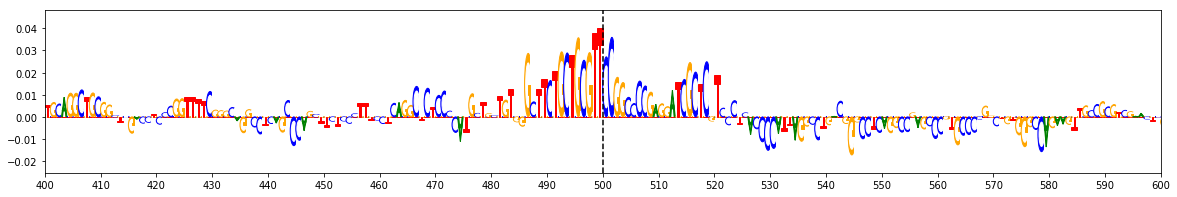

Noneffect Allele: C   ||  Explain Score: 0.5211   ||  Center / 200bp: 0.5981
Noneffect Sequence: CTGCTGCGTCCCGGCCCCGA


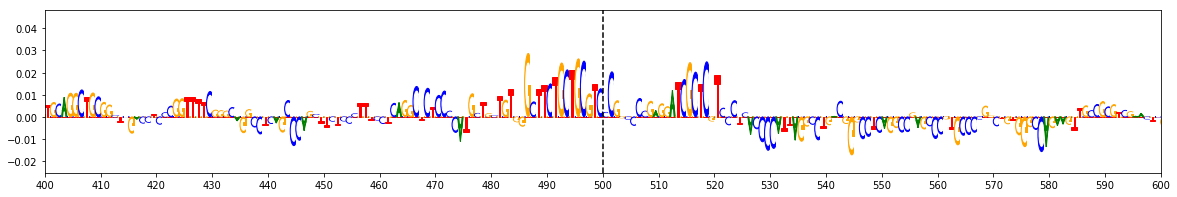

Allele Ratio : 1.4101   ||   Allele Difference : 0.2191  ||  ISM Score : 0.3456  ||  deltaSVM Score : 2.0005


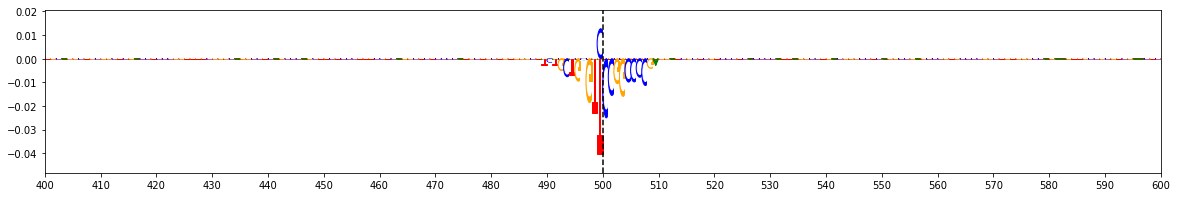


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs34806123   ||    chr4 : 89762970 - 89762971   ||    Locus: 429   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.20E-22

Coloc:  False

Effect Allele: G   ||  Explain Score: 1.1315   ||  Center / 200bp: 0.7351
Effect Sequence: ACAGTTGGTGAGTAGGAAAG


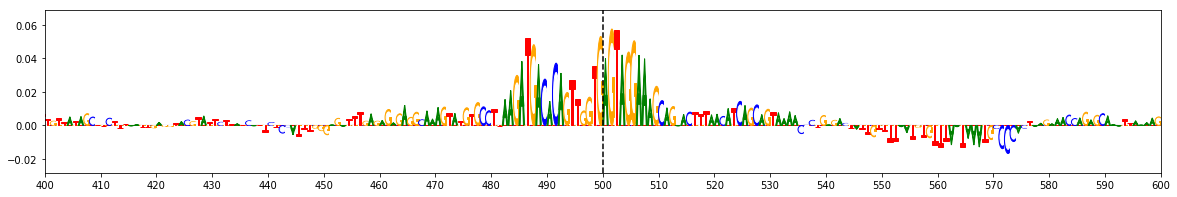

Noneffect Allele: A   ||  Explain Score: 0.8844   ||  Center / 200bp: 0.6845
Noneffect Sequence: ACAGTTGGTAAGTAGGAAAG


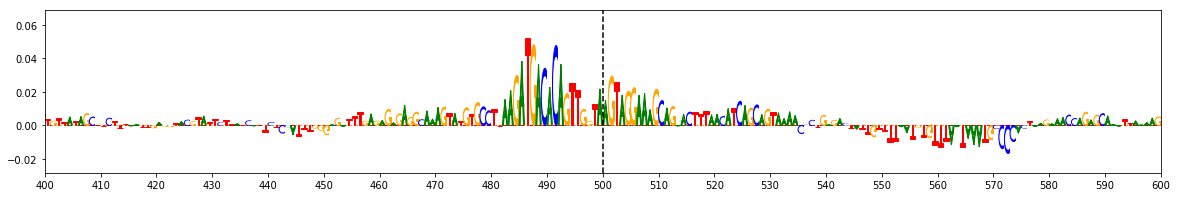

Allele Ratio : 1.2794   ||   Allele Difference : 0.2471  ||  ISM Score : 0.3867  ||  deltaSVM Score : 2.181


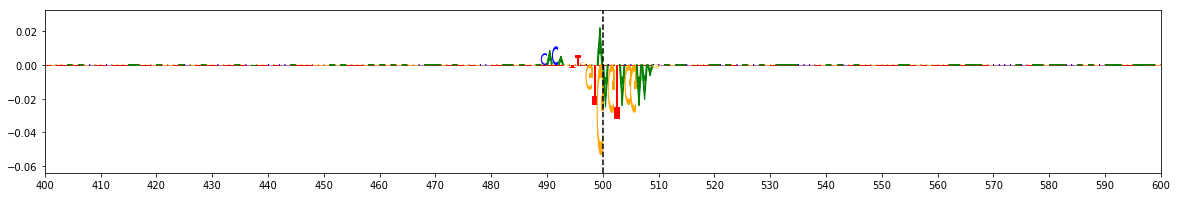


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1135173   ||    chr2 : 233146226 - 233146227   ||    Locus: 363   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  4.21E-08

Coloc:  False

Effect Allele: A   ||  Explain Score: 0.6513   ||  Center / 200bp: 0.6703
Effect Sequence: CCTGTTGTCATCCATTGAAG


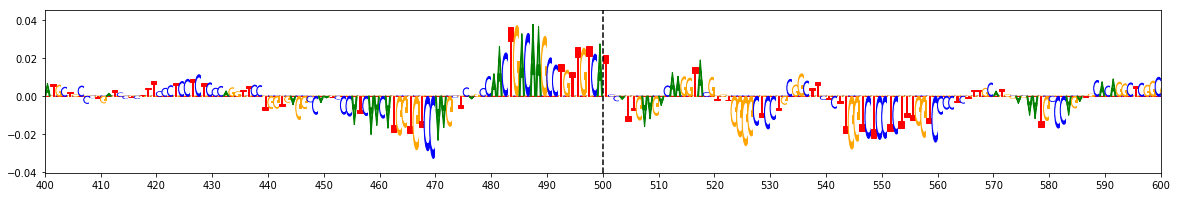

Noneffect Allele: G   ||  Explain Score: 0.4652   ||  Center / 200bp: 0.5922
Noneffect Sequence: CCTGTTGTCGTCCATTGAAG


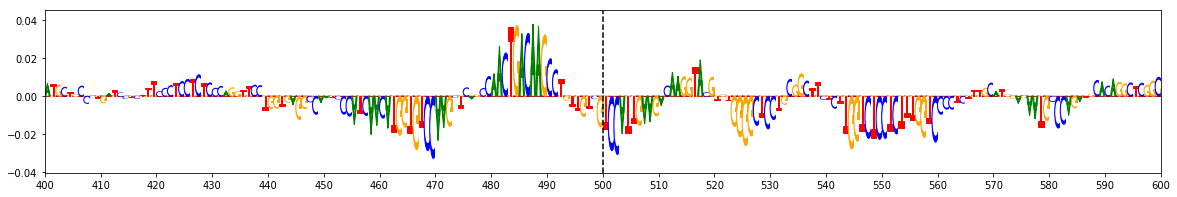

Allele Ratio : 1.4001   ||   Allele Difference : 0.3429  ||  ISM Score : 0.5358  ||  deltaSVM Score : 3.0697


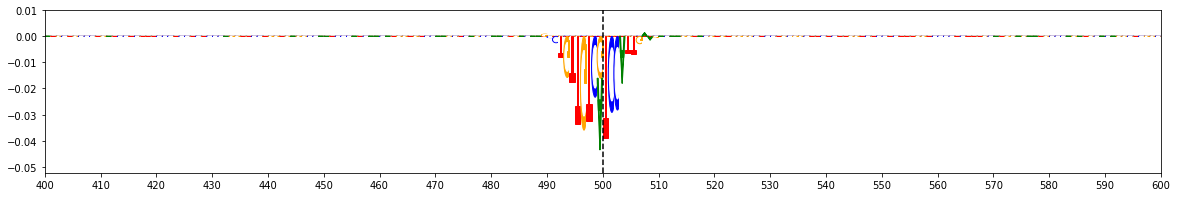


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12150090   ||    chr17 : 46038519 - 46038520   ||    Locus: 217   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.51E-22
Parkinsons_Pankratz_2012 	  4.06E-10

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.3531   ||  Center / 200bp: 0.5144
Effect Sequence: TCCGGCCAATCCCACACAGG


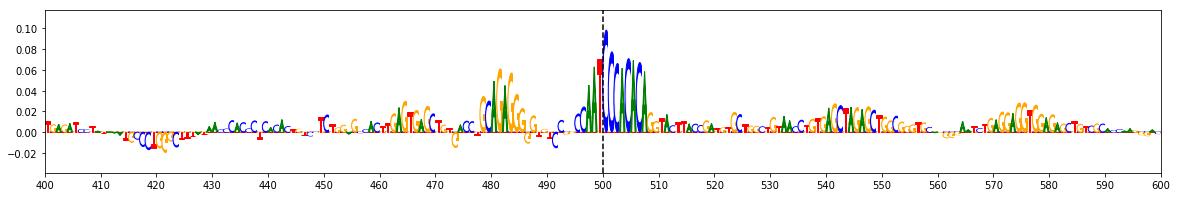

Noneffect Allele: C   ||  Explain Score: 0.7524   ||  Center / 200bp: 0.3713
Noneffect Sequence: TCCGGCCAACCCCACACAGG


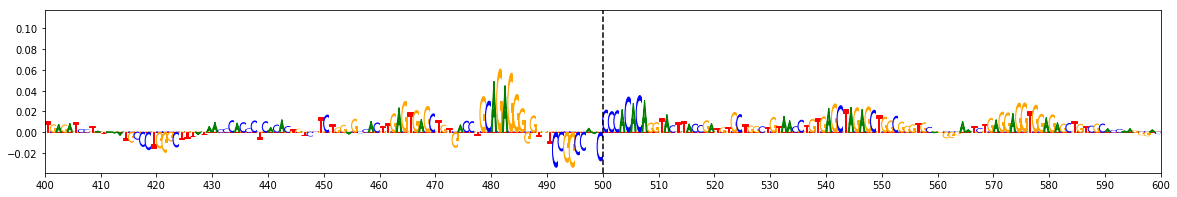

Allele Ratio : 1.7983   ||   Allele Difference : 0.7716  ||  ISM Score : 1.2061  ||  deltaSVM Score : 6.9939


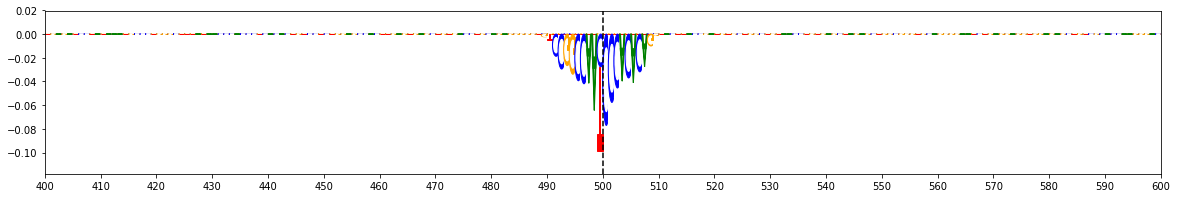


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs152137   ||    chr5 : 103224361 - 103224362   ||    Locus: 463   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  7.43E-03

Coloc:  False

Effect Allele: T   ||  Explain Score: 1.5999   ||  Center / 200bp: 0.5885
Effect Sequence: GGAGGTGGATCCCACTCACC


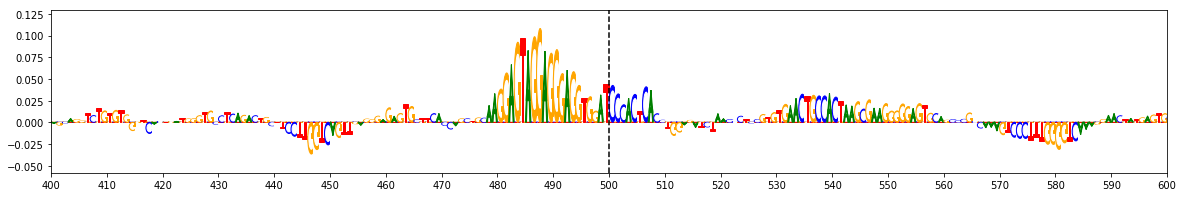

Noneffect Allele: C   ||  Explain Score: 1.0271   ||  Center / 200bp: 0.4784
Noneffect Sequence: GGAGGTGGACCCCACTCACC


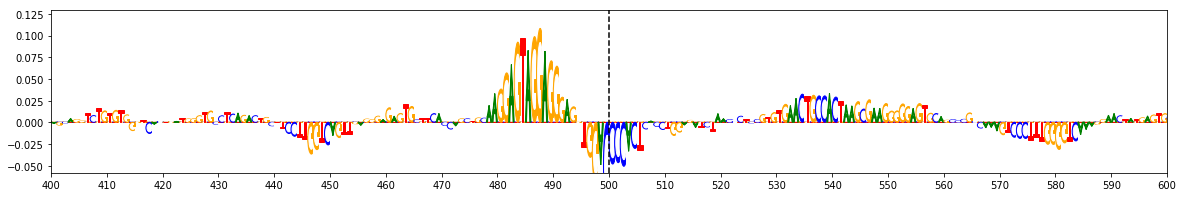

Allele Ratio : 1.5577   ||   Allele Difference : 1.1238  ||  ISM Score : 1.7499  ||  deltaSVM Score : 10.1578


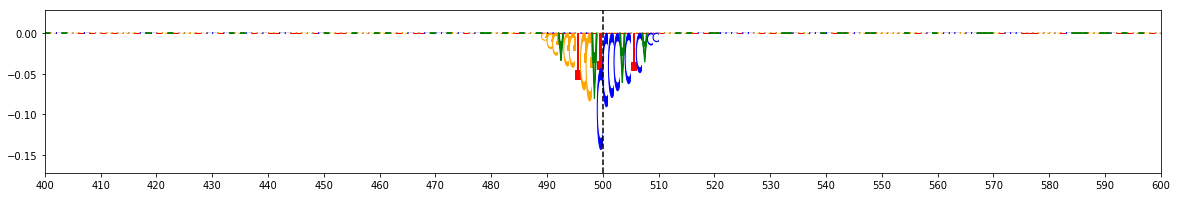


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2296887   ||    chr10 : 102245652 - 102245653   ||    Locus: 13   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  6.98E-03

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.3914   ||  Center / 200bp: 0.2492
Effect Sequence: GAAACAGGCTCCTTCTCTTC


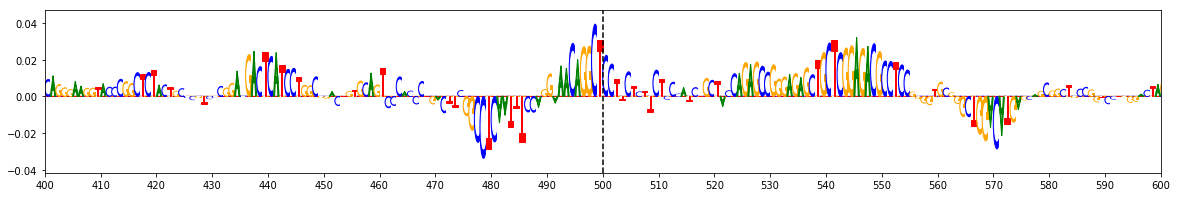

Noneffect Allele: C   ||  Explain Score: 0.1096   ||  Center / 200bp: 0.085
Noneffect Sequence: GAAACAGGCCCCTTCTCTTC


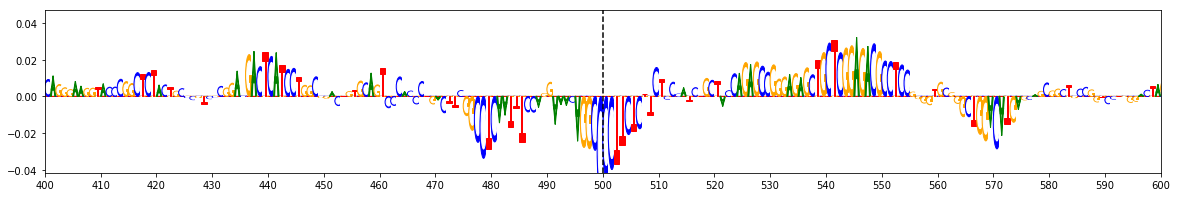

Allele Ratio : 3.5712   ||   Allele Difference : 0.6749  ||  ISM Score : 1.0511  ||  deltaSVM Score : 6.049


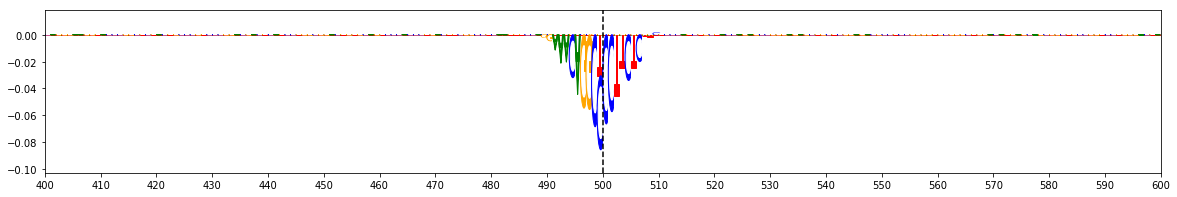


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1458202   ||    chr16 : 30941880 - 30941881   ||    Locus: 77   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  4.70E-05

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.6053   ||  Center / 200bp: 0.5751
Effect Sequence: ATCATAAACGAGGCTTCTGA


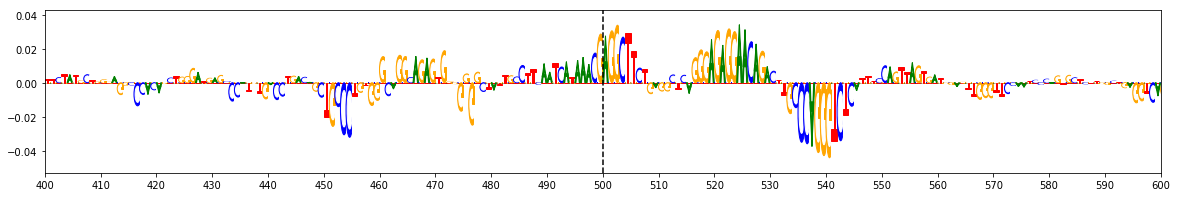

Noneffect Allele: A   ||  Explain Score: 0.3974   ||  Center / 200bp: 0.4706
Noneffect Sequence: ATCATAAACAAGGCTTCTGA


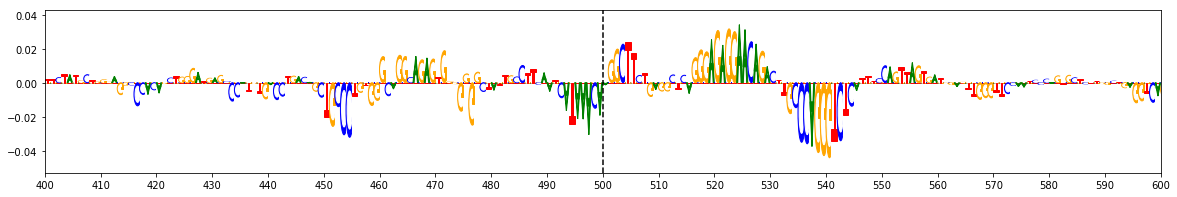

Allele Ratio : 1.5229   ||   Allele Difference : 0.3741  ||  ISM Score : 0.5824  ||  deltaSVM Score : 3.4193


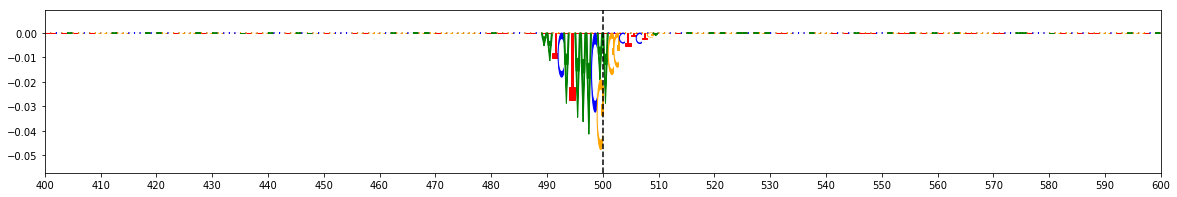


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs72800847   ||    chr16 : 31011317 - 31011318   ||    Locus: 82   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.45E-04

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.8573   ||  Center / 200bp: 0.4868
Effect Sequence: TTGTCCTTAGTGGGAGGGGA


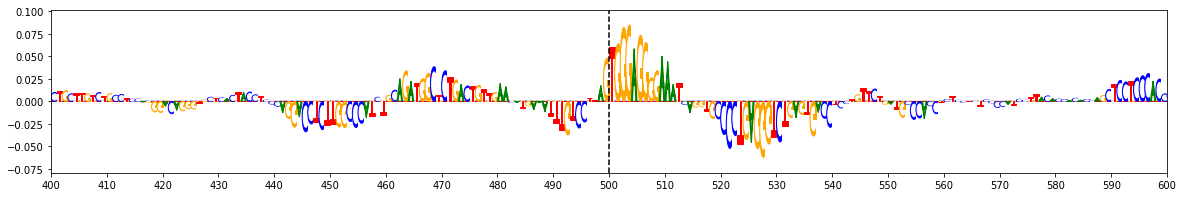

Noneffect Allele: A   ||  Explain Score: 0.4789   ||  Center / 200bp: 0.3463
Noneffect Sequence: TTGTCCTTAATGGGAGGGGA


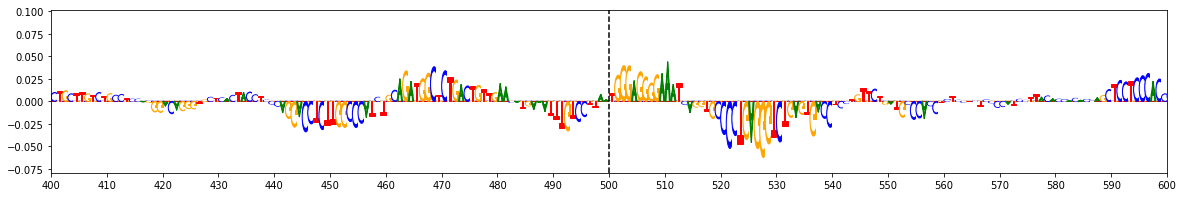

Allele Ratio : 1.7902   ||   Allele Difference : 0.3612  ||  ISM Score : 0.5697  ||  deltaSVM Score : 3.2463


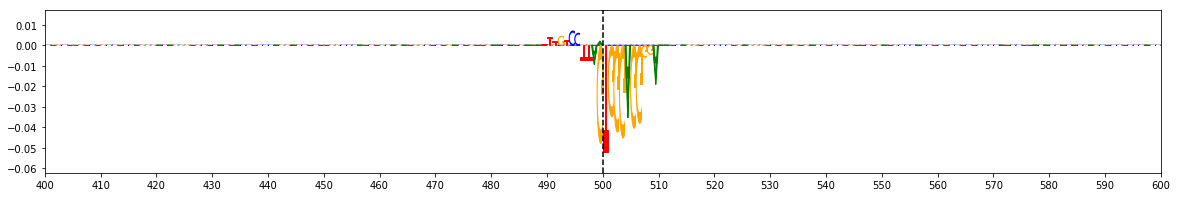


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs439401   ||    chr19 : 44911193 - 44911194   ||    Locus: 294   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  1.76E-165
Alzheimers_Kunkle_2019 		  7.61E-128
Alzheimers_Lambert_2013 	  3.54E-79

Coloc:  True

Effect Allele: T   ||  Explain Score: 2.0581   ||  Center / 200bp: 0.7452
Effect Sequence: ACTCTCTTCTCCTCCCACCC


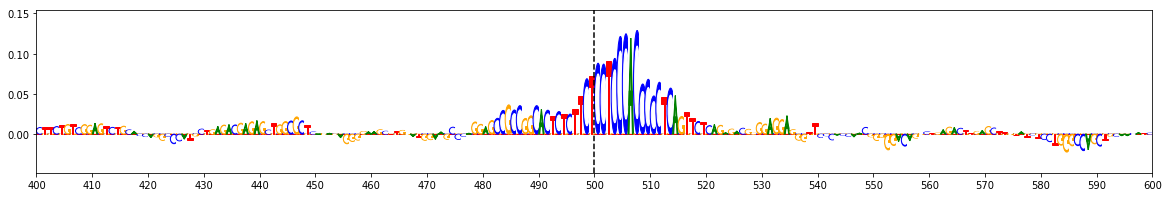

Noneffect Allele: C   ||  Explain Score: 1.7726   ||  Center / 200bp: 0.7164
Noneffect Sequence: ACTCTCTTCCCCTCCCACCC


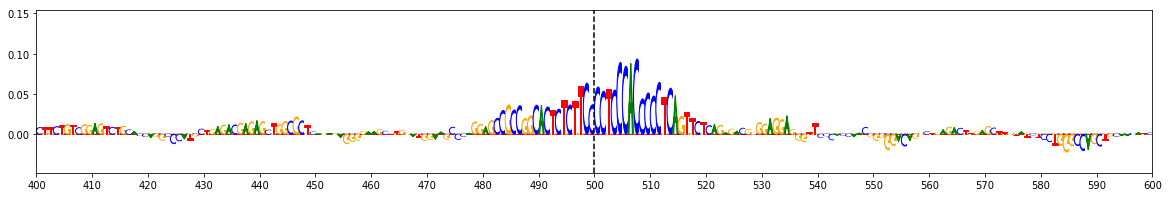

Allele Ratio : 1.1611   ||   Allele Difference : 0.2855  ||  ISM Score : 0.4431  ||  deltaSVM Score : 2.559


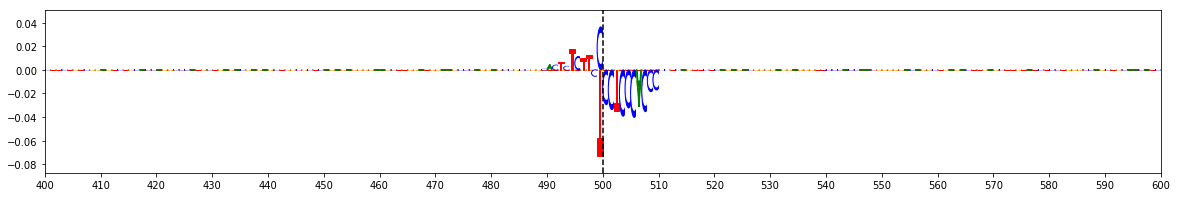


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs80346216   ||    chr17 : 45897109 - 45897110   ||    Locus: 191   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.5162   ||  Center / 200bp: 0.5916
Effect Sequence: GCCCGCCGCTAGGGGTTGCA


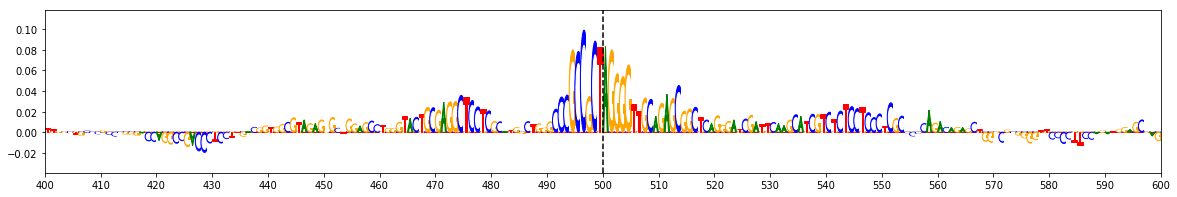

Noneffect Allele: G   ||  Explain Score: 1.0735   ||  Center / 200bp: 0.5066
Noneffect Sequence: GCCCGCCGCGAGGGGTTGCA


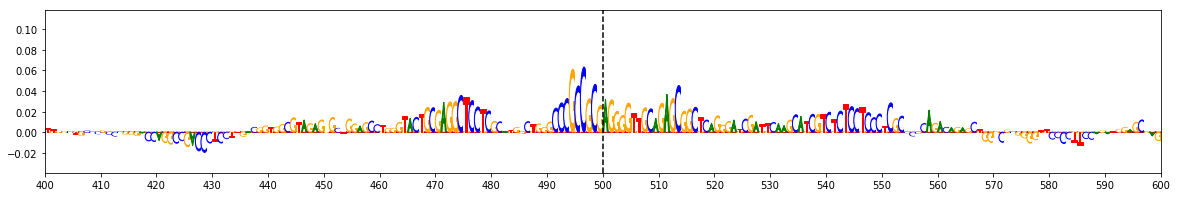

Allele Ratio : 1.4123   ||   Allele Difference : 0.4426  ||  ISM Score : 0.6905  ||  deltaSVM Score : 3.9312


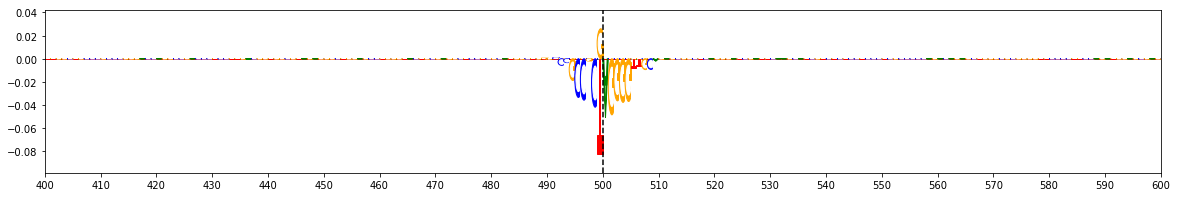


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs113661575   ||    chr5 : 134594466 - 134594467   ||    Locus: 467   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  3.40E-02

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.7835   ||  Center / 200bp: 0.5128
Effect Sequence: CTCAGCCTCGCAAAGTGCTG


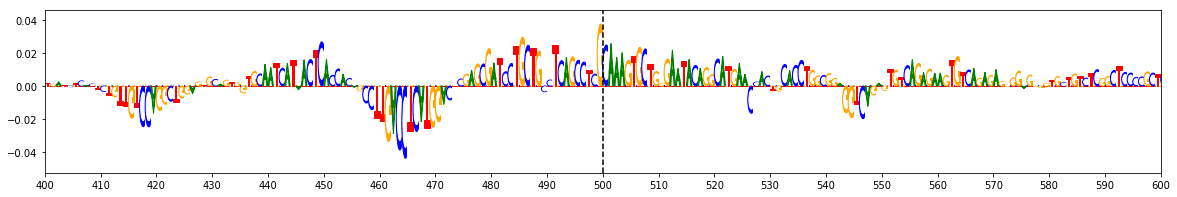

Noneffect Allele: C   ||  Explain Score: 0.4861   ||  Center / 200bp: 0.3961
Noneffect Sequence: CTCAGCCTCCCAAAGTGCTG


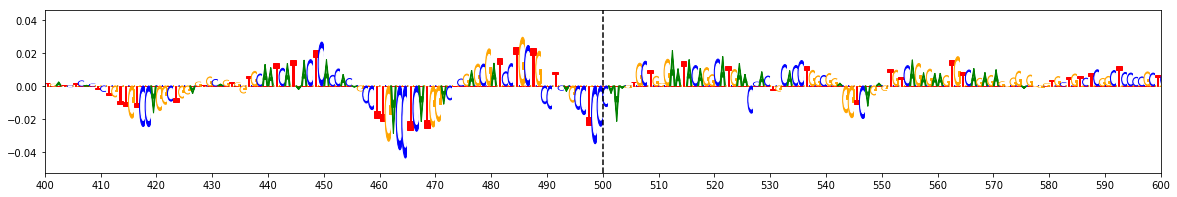

Allele Ratio : 1.6118   ||   Allele Difference : 0.4893  ||  ISM Score : 0.8476  ||  deltaSVM Score : 4.9168


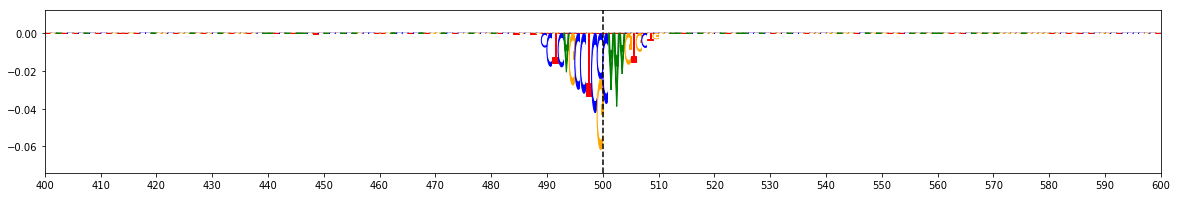


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3775427   ||    chr4 : 89765967 - 89765968   ||    Locus: 431   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.74E-12

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.9873   ||  Center / 200bp: 0.5446
Effect Sequence: AAAAATTATGTAATGCAATG


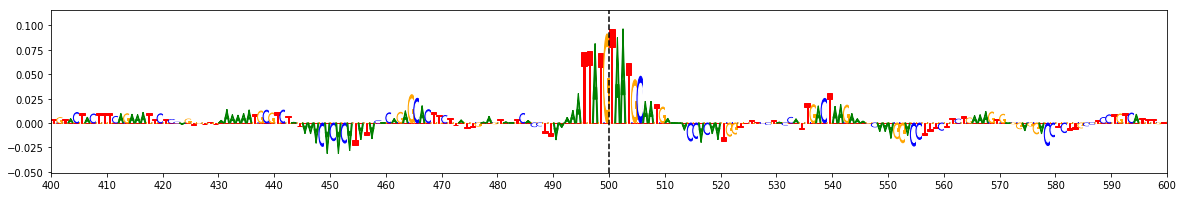

Noneffect Allele: A   ||  Explain Score: 0.6913   ||  Center / 200bp: 0.4565
Noneffect Sequence: AAAAATTATATAATGCAATG


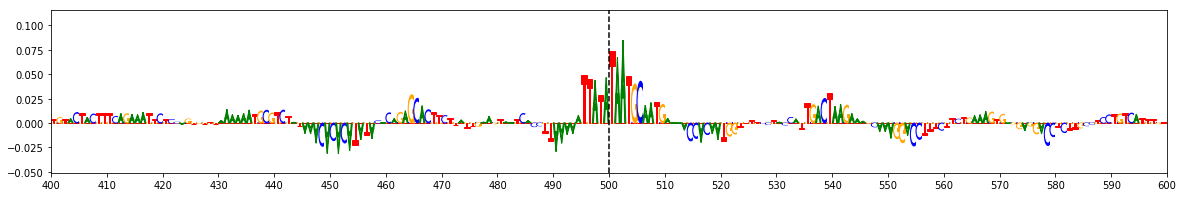

Allele Ratio : 1.4282   ||   Allele Difference : 0.3515  ||  ISM Score : 0.5554  ||  deltaSVM Score : 3.2034


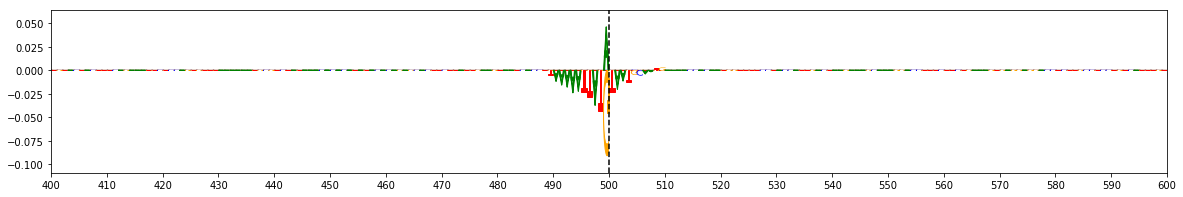


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [8]:
for idx in pos_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], ':', pos_snps.at[idx, 'start'], '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in pos_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
        
    print("Coloc: ", pos_snps.at[idx, 'coloc'])
    
    print()
    
    print('Effect Allele:', pos_snps.at[idx, 'effect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'effect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence:', effect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'noneffect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence:', noneffect_seqs[idx][490:510])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(pos_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(pos_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(pos_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(pos_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()